# Predict Next-Day Stock Price

In this short notebook, the next-day Amazon stock price is predicted using 
- **RNN** 
- **LSTM**
- **GRU**

Inspired from the [Medium article](https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346).

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
from keras.metrics import MeanSquaredError
from keras.optimizers import SGD, Adam

In [2]:
# Set plotting style of matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

### Download Amazon Stock Price Data

In [3]:
AMZN = yfinance.download('AMZN',
                         start = '2013-01-01',
                         end = '2019-12-31',
                         progress = False)

AMZN

Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2013-01-02  12.804000  12.905000  12.663000  12.865500  12.865500   65420000
2013-01-03  12.863500  13.044000  12.818500  12.924000  12.924000   55018000
2013-01-04  12.879000  12.990000  12.832500  12.957500  12.957500   37484000
2013-01-07  13.148500  13.486500  13.133500  13.423000  13.423000   98200000
2013-01-08  13.353500  13.449000  13.178500  13.319000  13.319000   60214000
...               ...        ...        ...        ...        ...        ...
2019-12-23  89.413002  89.650002  89.225502  89.650002  89.650002   42728000
2019-12-24  89.690498  89.778503  89.378998  89.460503  89.460503   17626000
2019-12-26  90.050499  93.523003  89.974998  93.438499  93.438499  120108000
2019-12-27  94.146004  95.070000  93.300499  93.489998  93.489998  123732000
2019-12-30  93.699997  94.199997  92.030998  92.344498  92.344498   73494000

[1761 rows x 6 columns]

There are 5 different stock price columns that we can use/predict: *Open, High, Low, Close, Adj Close*. I will use *Adj Close* price. Closing price simply refers to the cost of shares at the end of the day, the adjusted closing price takes dividends, stock splits, and new stock offerings into account. The adjusted closing price is a more accurate indicator of stock value since it starts where the closing price finishes.

Keep only "Adj Close" column

In [4]:
all_data = AMZN[['Adj Close']].round(2)

all_data

Adj Close
Date                 
2013-01-02      12.87
2013-01-03      12.92
2013-01-04      12.96
2013-01-07      13.42
2013-01-08      13.32
...               ...
2019-12-23      89.65
2019-12-24      89.46
2019-12-26      93.44
2019-12-27      93.49
2019-12-30      92.34

[1761 rows x 1 columns]

In [5]:
all_data.describe()

Adj Close
count  1761.000000
mean     44.287019
std      28.843229
min      12.410000
25%      17.930000
50%      36.340000
75%      74.850000
max     101.980000

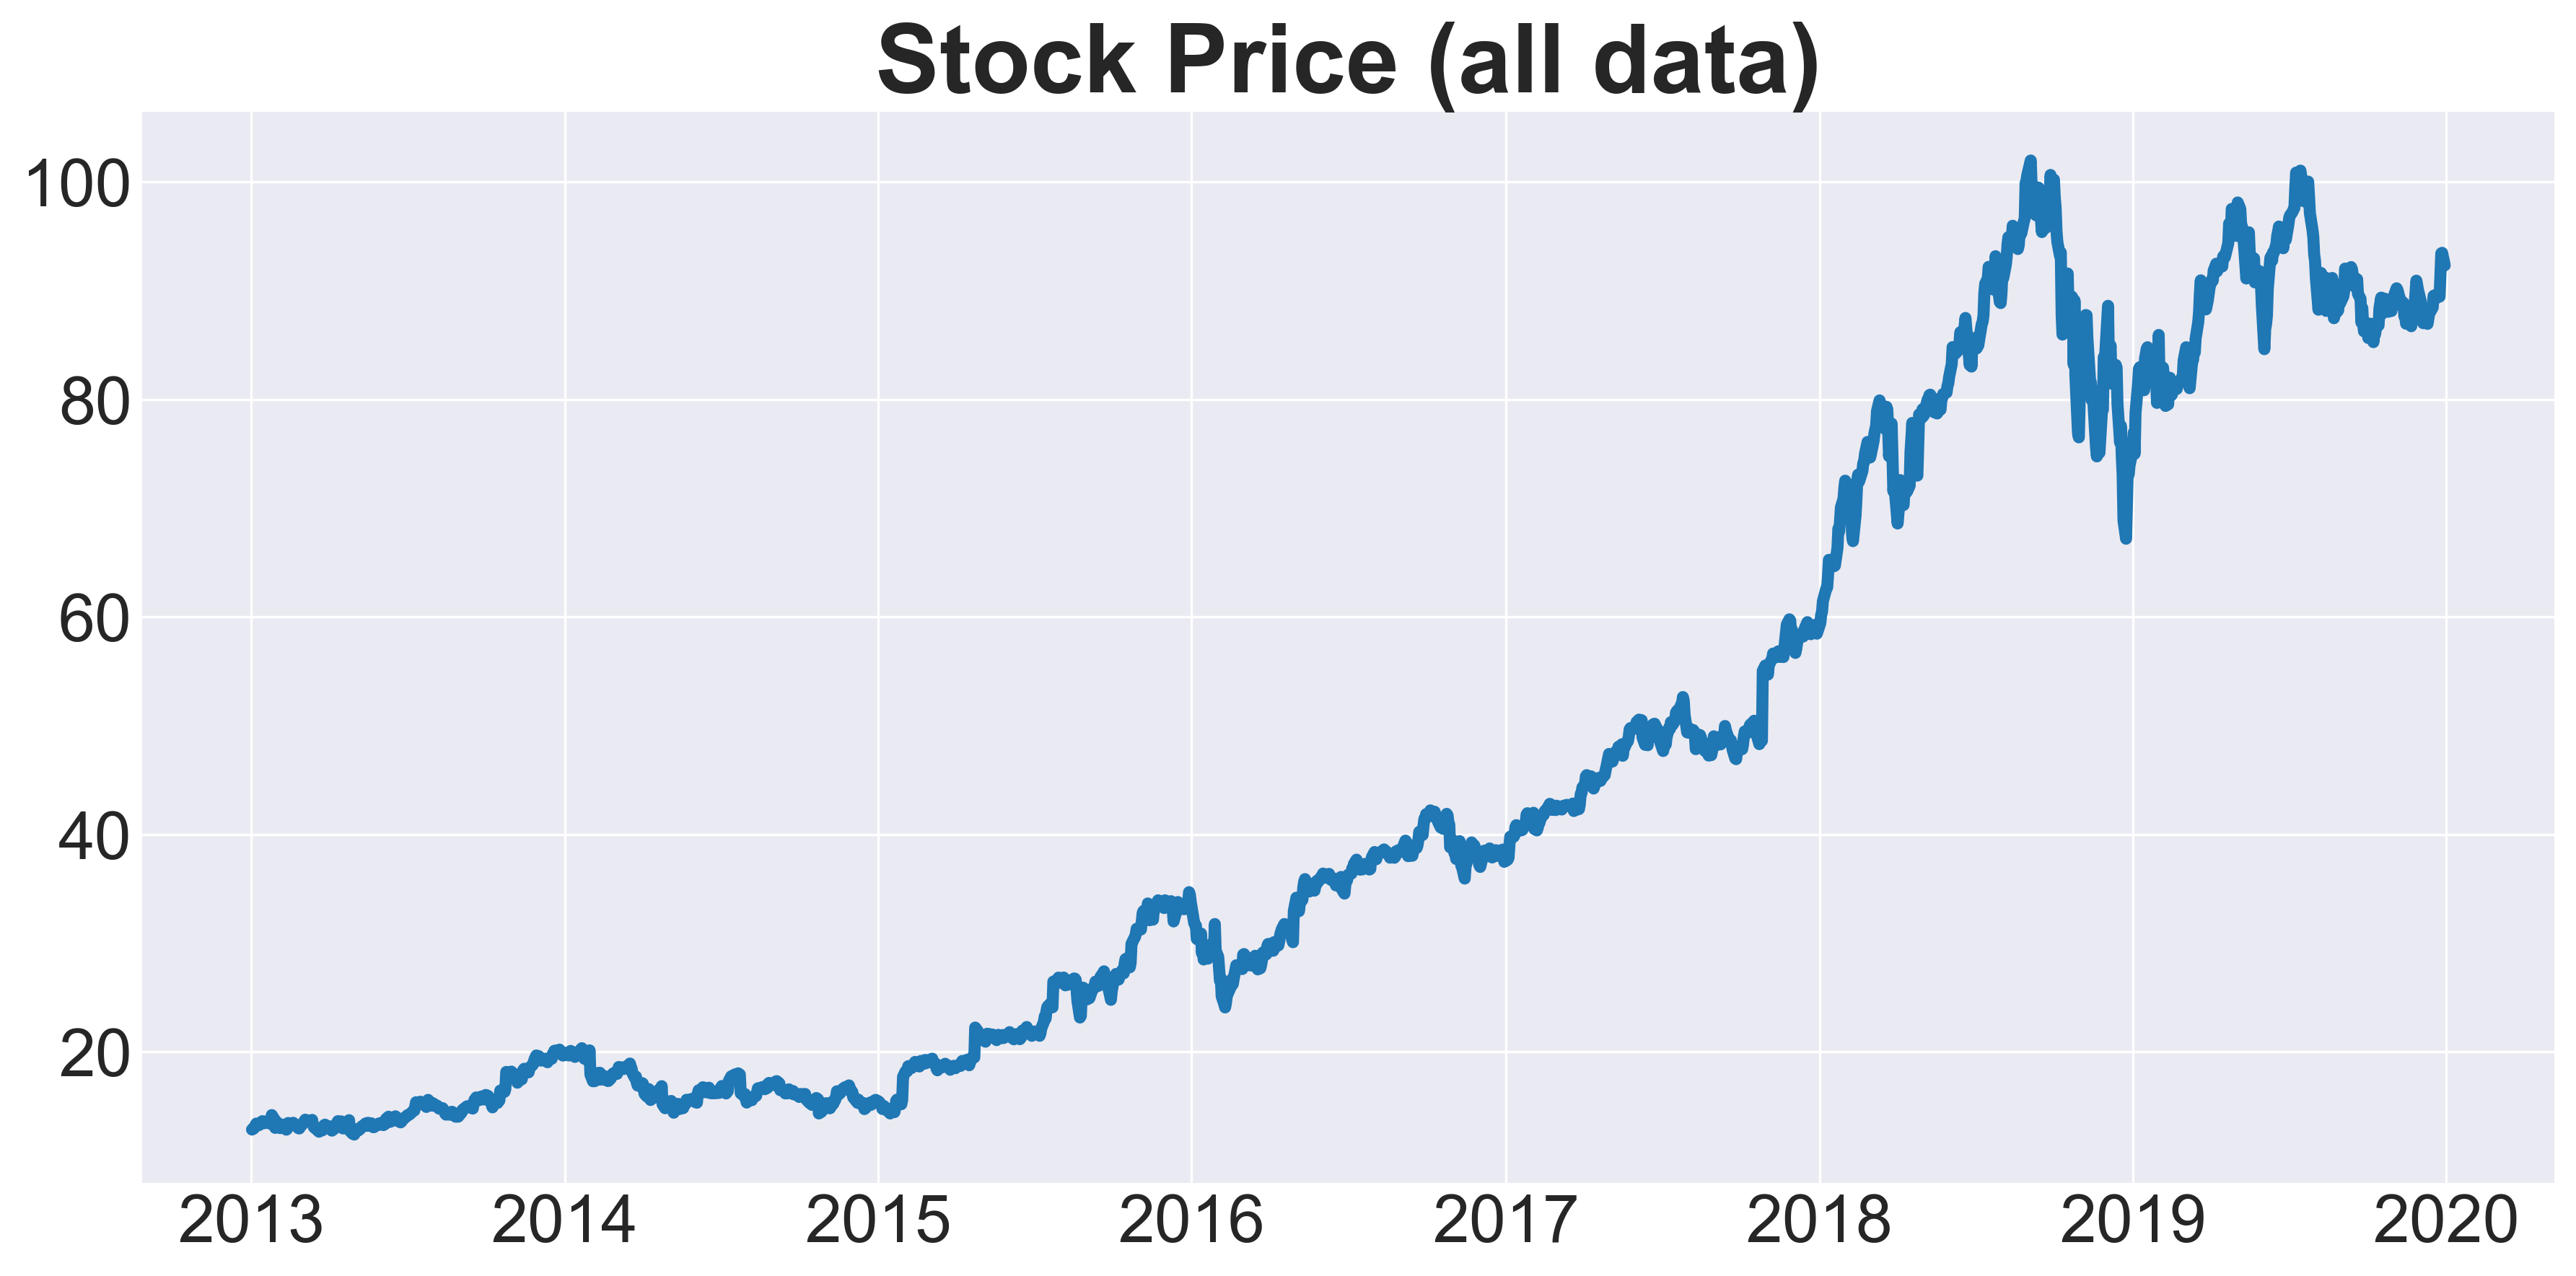

In [6]:
fig, ax = plt.subplots(figsize=(12,6), dpi=300)

ax.plot(all_data['Adj Close'], lw=4)

ax.set_title('Stock Price (all data)', 
             fontsize=32, fontweight='bold')
ax.tick_params(axis='both', which='major', 
               labelsize=22)

fig.tight_layout()
fig.savefig('Figures/all_data.jpg', dpi=500)

### Create training and test sets

I am going to use daily prices from 2013 to 2018 as the training data, and 2019 as the test data.

In [7]:
print(f"{all_data[:'2018'].shape[0]} observations from 2013 to 2018")
print(f"{all_data['2019':].shape[0]} observations in 2019")

1510 observations from 2013 to 2018
251 observations in 2019


Now, we need to specify the number of days to be considered to predict the next day stock price. I chose 7 days of time window to predict the next day stock price. This "hyperparameter" can be further tuned later.    

In [8]:
# Num of days to be considered to predict next day price
n_steps = 7  

In [9]:
def create_train_test(all_data, n_steps):
    '''
    create training and test set
    input:
        all_data: dataframe with dates and price 
        n_steps: num of days to be considered 
        to predict next day price
    output:
        X_train, Y_train
        X_test, Y_test
    '''
    train_len = all_data[:'2018'].shape[0]
    test_len = all_data['2019':].shape[0]
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    # Test set must start n_steps 
    # before the first day of 2019 so that 
    # the first day of 2019 can be predicted 
    # as the first element of the test set
    for i in range(train_len - 2 * n_steps):
        X_train.append(all_data.iloc[i : i+n_steps]['Adj Close'].values)
        Y_train.append(all_data.iloc[i+n_steps]['Adj Close'])

    for i in range(train_len - n_steps, train_len + test_len - n_steps):
        X_test.append(all_data.iloc[i : i+n_steps]['Adj Close'].values)
        Y_test.append(all_data.iloc[i+n_steps]['Adj Close'])
        
    X_train = np.asarray(X_train)
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

    X_test = np.asarray(X_test)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

    Y_train = np.asarray(Y_train)
    Y_train = Y_train.reshape(Y_train.shape[0],1)

    Y_test = np.asarray(Y_test)
    Y_test = Y_test.reshape(Y_test.shape[0],1)

    return X_train, Y_train , X_test, Y_test

X_train, Y_train, X_test, Y_test = create_train_test(all_data, n_steps)

In [10]:
print (f'X_train shape: {X_train.shape} \nY_train shape: {Y_train.shape}\
       \nX_test_shape: {X_test.shape} \nY_test_shape: {Y_test.shape}')

X_train shape: (1496, 7, 1) 
Y_train shape: (1496, 1)       
X_test_shape: (251, 7, 1) 
Y_test_shape: (251, 1)


## RNN (simple model)

### Build model

In [11]:
simple_rnn_model = Sequential()

simple_rnn_model.add(SimpleRNN(units=32, activation='tanh', 
                               input_shape=(n_steps, 1)))

simple_rnn_model.add(Dense(units=1)) # Time step of the output

simple_rnn_model.compile(optimizer='rmsprop', 
                         loss='mean_squared_error')

simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Fit model

In [12]:
# Save training history
simple_rnn_history = simple_rnn_model.fit(X_train, Y_train, 
                                          validation_split=0.2,
                                          epochs=100, 
                                          batch_size=32, 
                                          verbose=False)

### Make predictions

In [13]:
simple_rnn_preds_test = simple_rnn_model.predict(X_test)
mse = MeanSquaredError()
simple_rnn_mse_test = mse(Y_test, simple_rnn_preds_test).numpy()
print (f'MSE test: {simple_rnn_mse_test:.2f}')

8/8 [==============================] - 0s 4ms/step
MSE test: 1441.25


### Plot

In [14]:
def plot_loss_preds(fit_history, preds_test):
    '''
    Plot traning and validation loss vs. epoch no
    Plot prediction and actual test vs. days
    input:
        fit_history = model.fit(....)
        preds_test: predictions for the test set
    output:
        ax1 and ax2 objects of two plots
    '''
    
    # Plot traning and validation loss vs. epoch no
    fig1, ax1 = plt.subplots(figsize=(12,6), dpi=300)

    ax1.plot(fit_history.history['loss'], color='tab:green',
             label='Training', lw=7)
    ax1.plot(fit_history.history['val_loss'], color='tab:red',
             label='Validation', lw=7)

    ax1.set_title('Loss (MSE) during training',
                  fontsize=30, fontweight='bold')
    ax1.spines[['right', 'top']].set_visible(False)
    ax1.tick_params(axis='both', which='major', 
                    labelsize=22)
    ax1.legend(fontsize=28)
    
    fig1.tight_layout()
    fig1.savefig('Figures/loss_vs_epoch.jpg', 
                 dpi=500)


    # Plot prediction and actual test vs. days
    fig2, ax2 = plt.subplots(figsize=(12,6), dpi=300)

    # create a df for the preds of 2019 along with its date column
    df_preds = pd.DataFrame(index= all_data['2019':].index,
                            data= {'Adj Close':preds_test[:,0]})

    ax2.plot(all_data['2019':]['Adj Close'], 
             label='Actual', lw=5)
    ax2.plot(df_preds['Adj Close'], 
             label='Prediction', lw=5)
    ax2.set_title('Actual vs. Prediction (test set)',
                  fontsize=30, fontweight='bold')
    ax2.spines[['right', 'top']].set_visible(False)
    ax2.tick_params(axis='both', which='major', 
                    labelsize=22)
    ax2.legend(fontsize=28)

    fig2.tight_layout()
    fig2.savefig('Figures/actual_vs_prediction.jpg', 
                 dpi=500)


    return ax1, ax2

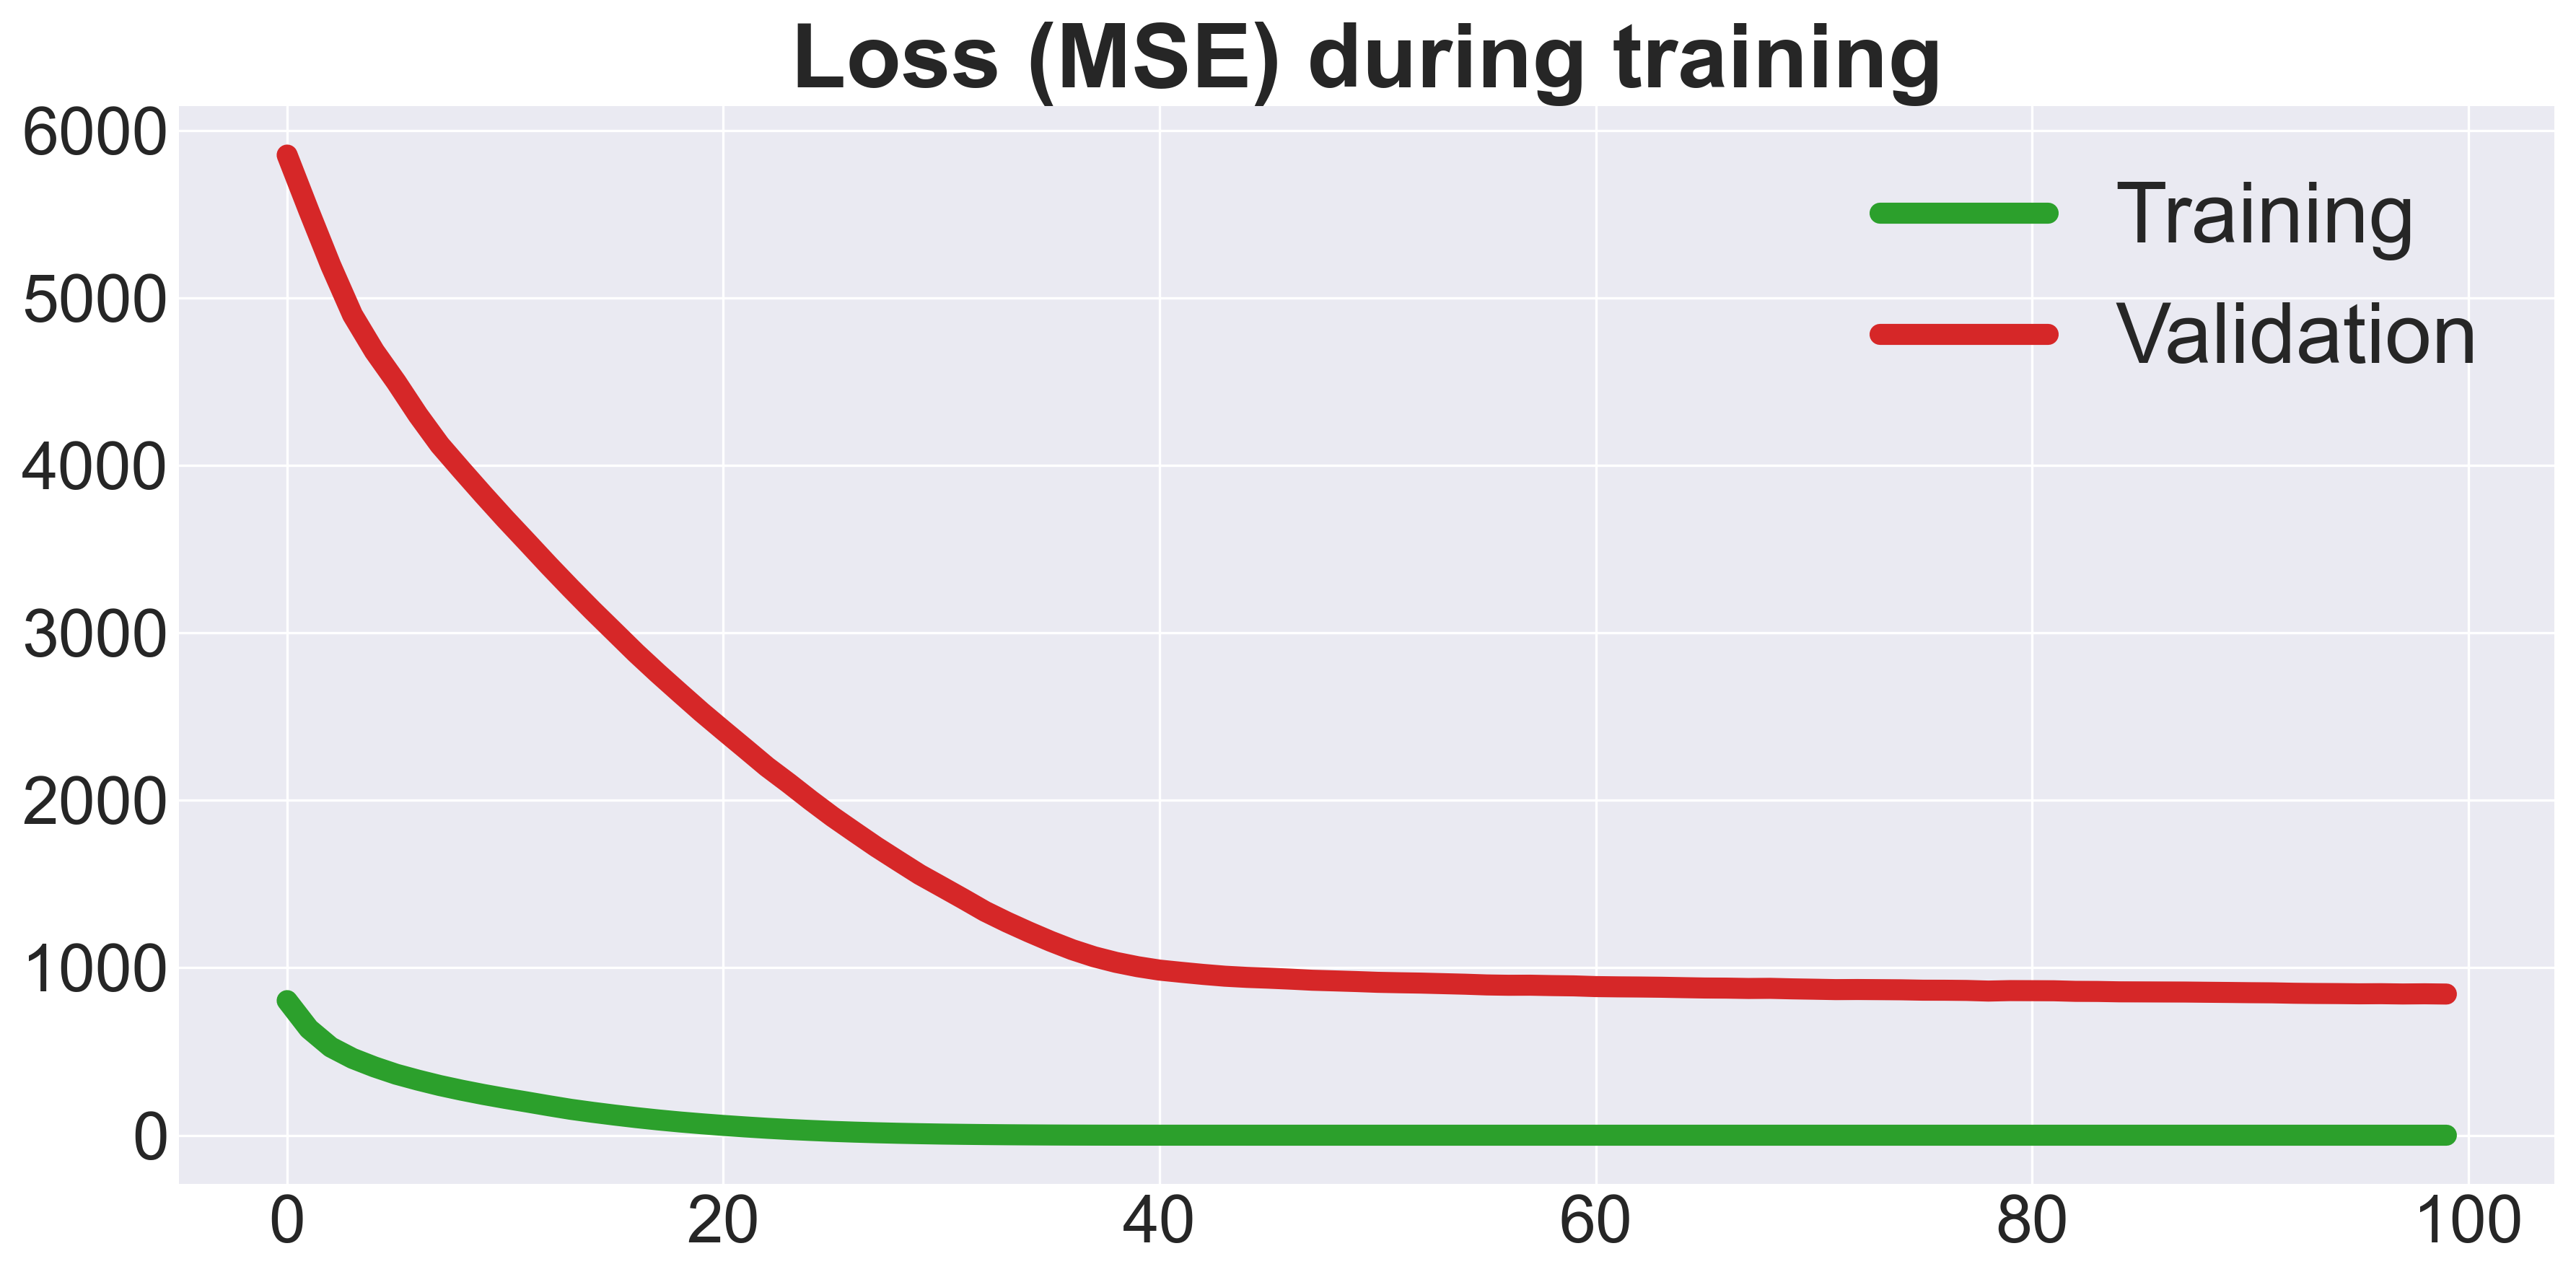

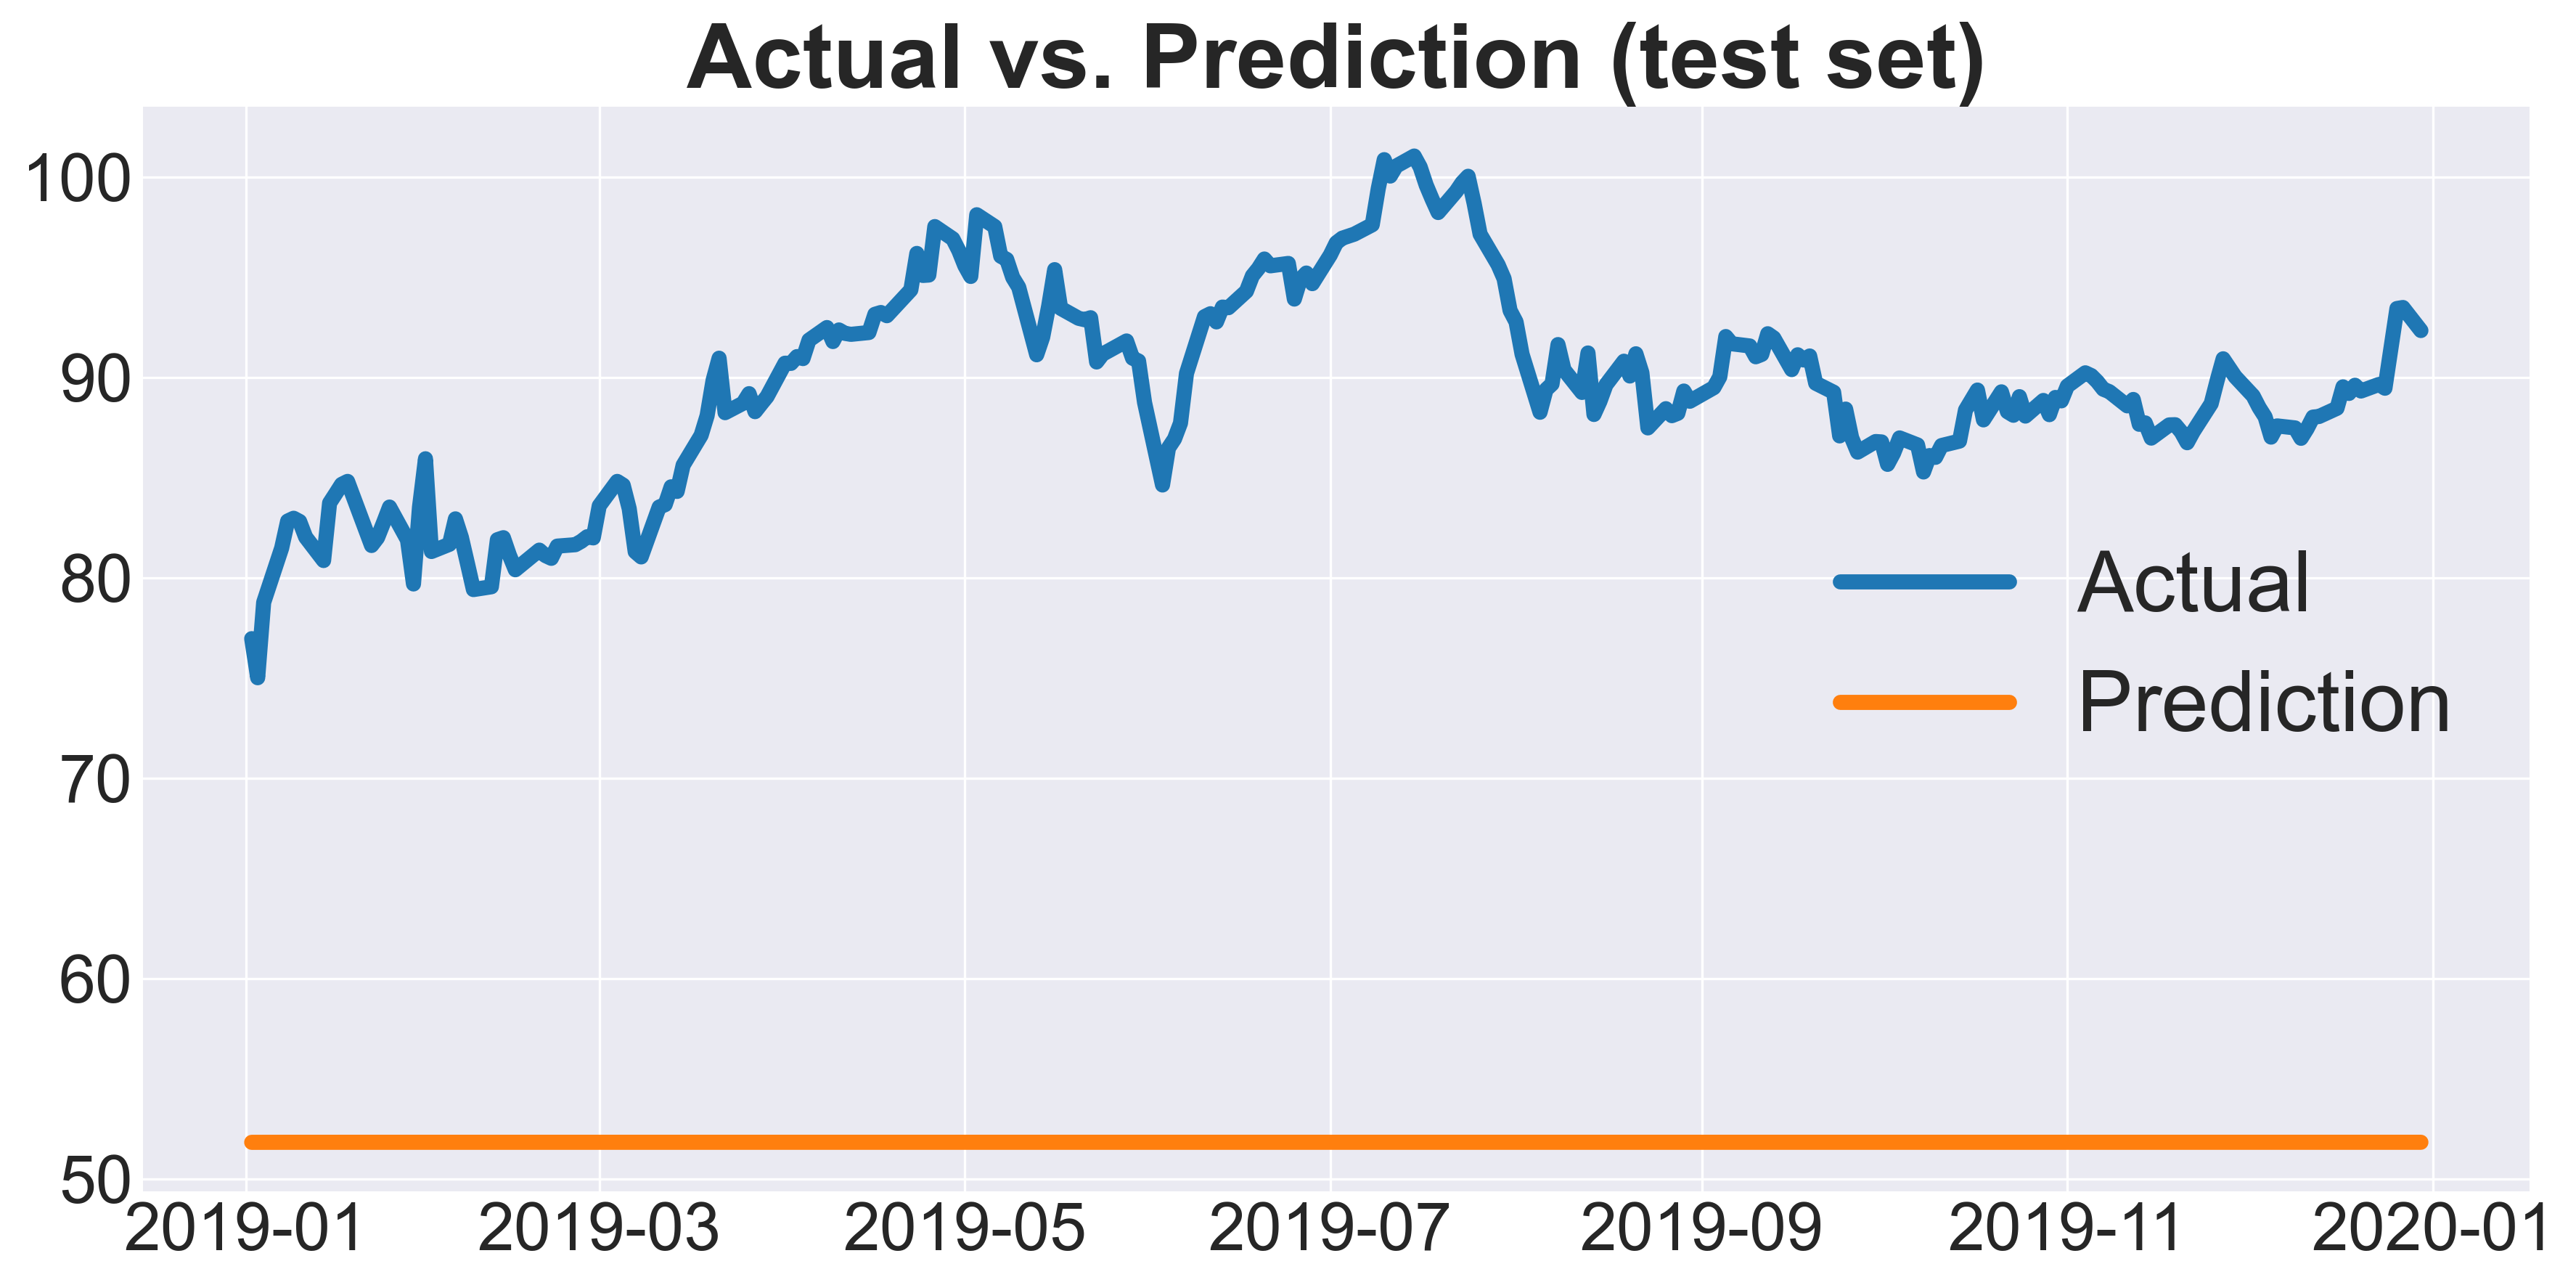

In [15]:
_ = plot_loss_preds(simple_rnn_history, 
                    simple_rnn_preds_test)

<u>Comments</u>

Terrible performance! The reason is we did NOT normalize the data. It's a good practice to normalize data before rnn, lstm etc.

## RNN (normalized)

### Normalize training and test set

In [16]:
def normalize_training_test(X_train, Y_train, 
                            X_test, Y_test, 
                            all_data):
    '''
    input:
        X_train, Y_train, X_test, Y_test, all_data
    output:
        X_train_norm, Y_train_norm, X_test_norm, Y_test_norm, scaler
    '''
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(all_data.loc[:'2018', 'Adj Close'].values.reshape(-1,1))

    normalizer = lambda input_arr: \
        scaler.transform(input_arr.reshape(-1, input_arr.shape[-1])).reshape(input_arr.shape)

    return normalizer(X_train), normalizer(Y_train), normalizer(X_test), normalizer(Y_test), scaler

X_train_norm, Y_train_norm, X_test_norm, Y_test_norm, scaler = \
    normalize_training_test(X_train, Y_train, X_test, Y_test, all_data)

In [17]:
rnn_norm_model = Sequential()

rnn_norm_model.add(SimpleRNN(units=32, activation='tanh', 
                             input_shape=(n_steps, 1)))

rnn_norm_model.add(Dense(units=1)) # The time step of the output

rnn_norm_model.compile(optimizer='rmsprop', 
                       loss='mean_squared_error')

rnn_norm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
rnn_norm_history = rnn_norm_model.fit(X_train_norm, Y_train_norm, 
                                      validation_split=0.2,
                                      epochs=100, 
                                      batch_size=16, 
                                      verbose=False)

In [19]:
def predict_print_MSE(model_history, scaler):
    '''
    Predict test set using model trained on normalized data
    input:
        model_history = model.fit(....)
        scaler: obtained when training data is scaled 
        e.g. MinMaxScaler
    output:
        predictions for test set
    '''
    model = model_history.model
    preds_test_norm = model.predict(X_test_norm)
    preds_test = scaler.inverse_transform(preds_test_norm)

    mse_test = MeanSquaredError()(Y_test, preds_test).numpy()
    print (f'MSE test: {mse_test:.2f}')

    mse_val = model_history.history['val_loss'][-1]
    print(f'MSE validation: {mse_val:.1e}')

    mse_train = model_history.history['loss'][-1]
    print(f'MSE training: {mse_train:.1e}')

    return preds_test

In [20]:
rnn_norm_preds_test = predict_print_MSE(rnn_norm_history, scaler)

8/8 [==============================] - 0s 4ms/step
MSE test: 6.96
MSE validation: 7.1e-04
MSE training: 3.6e-05


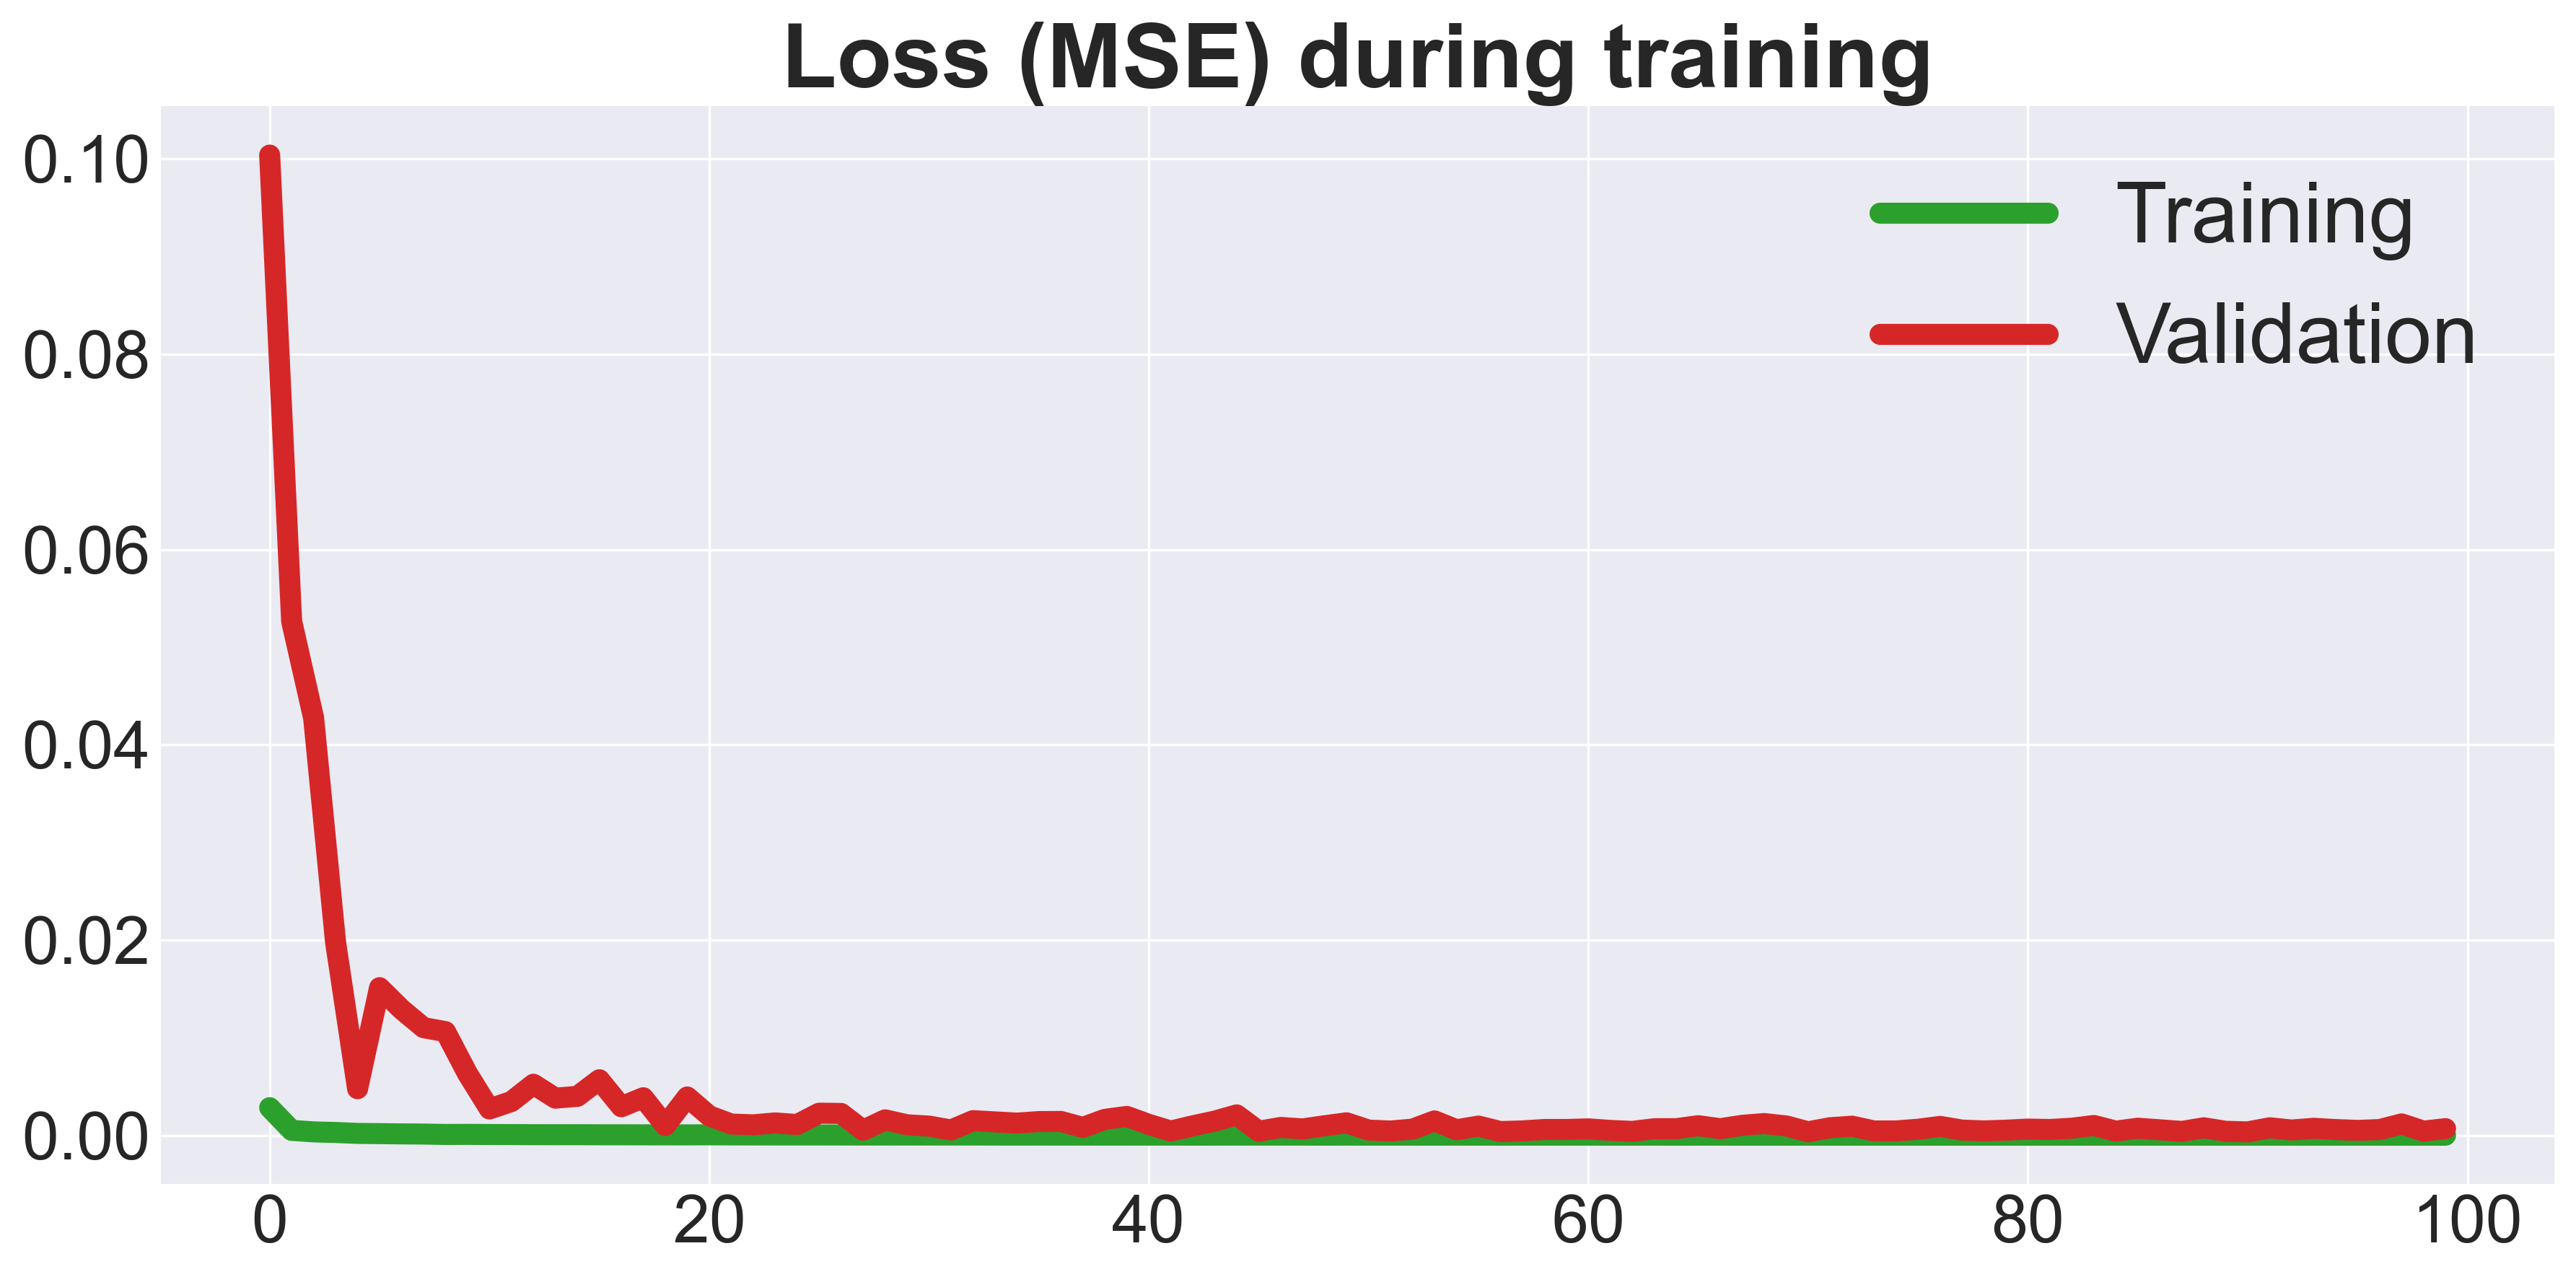

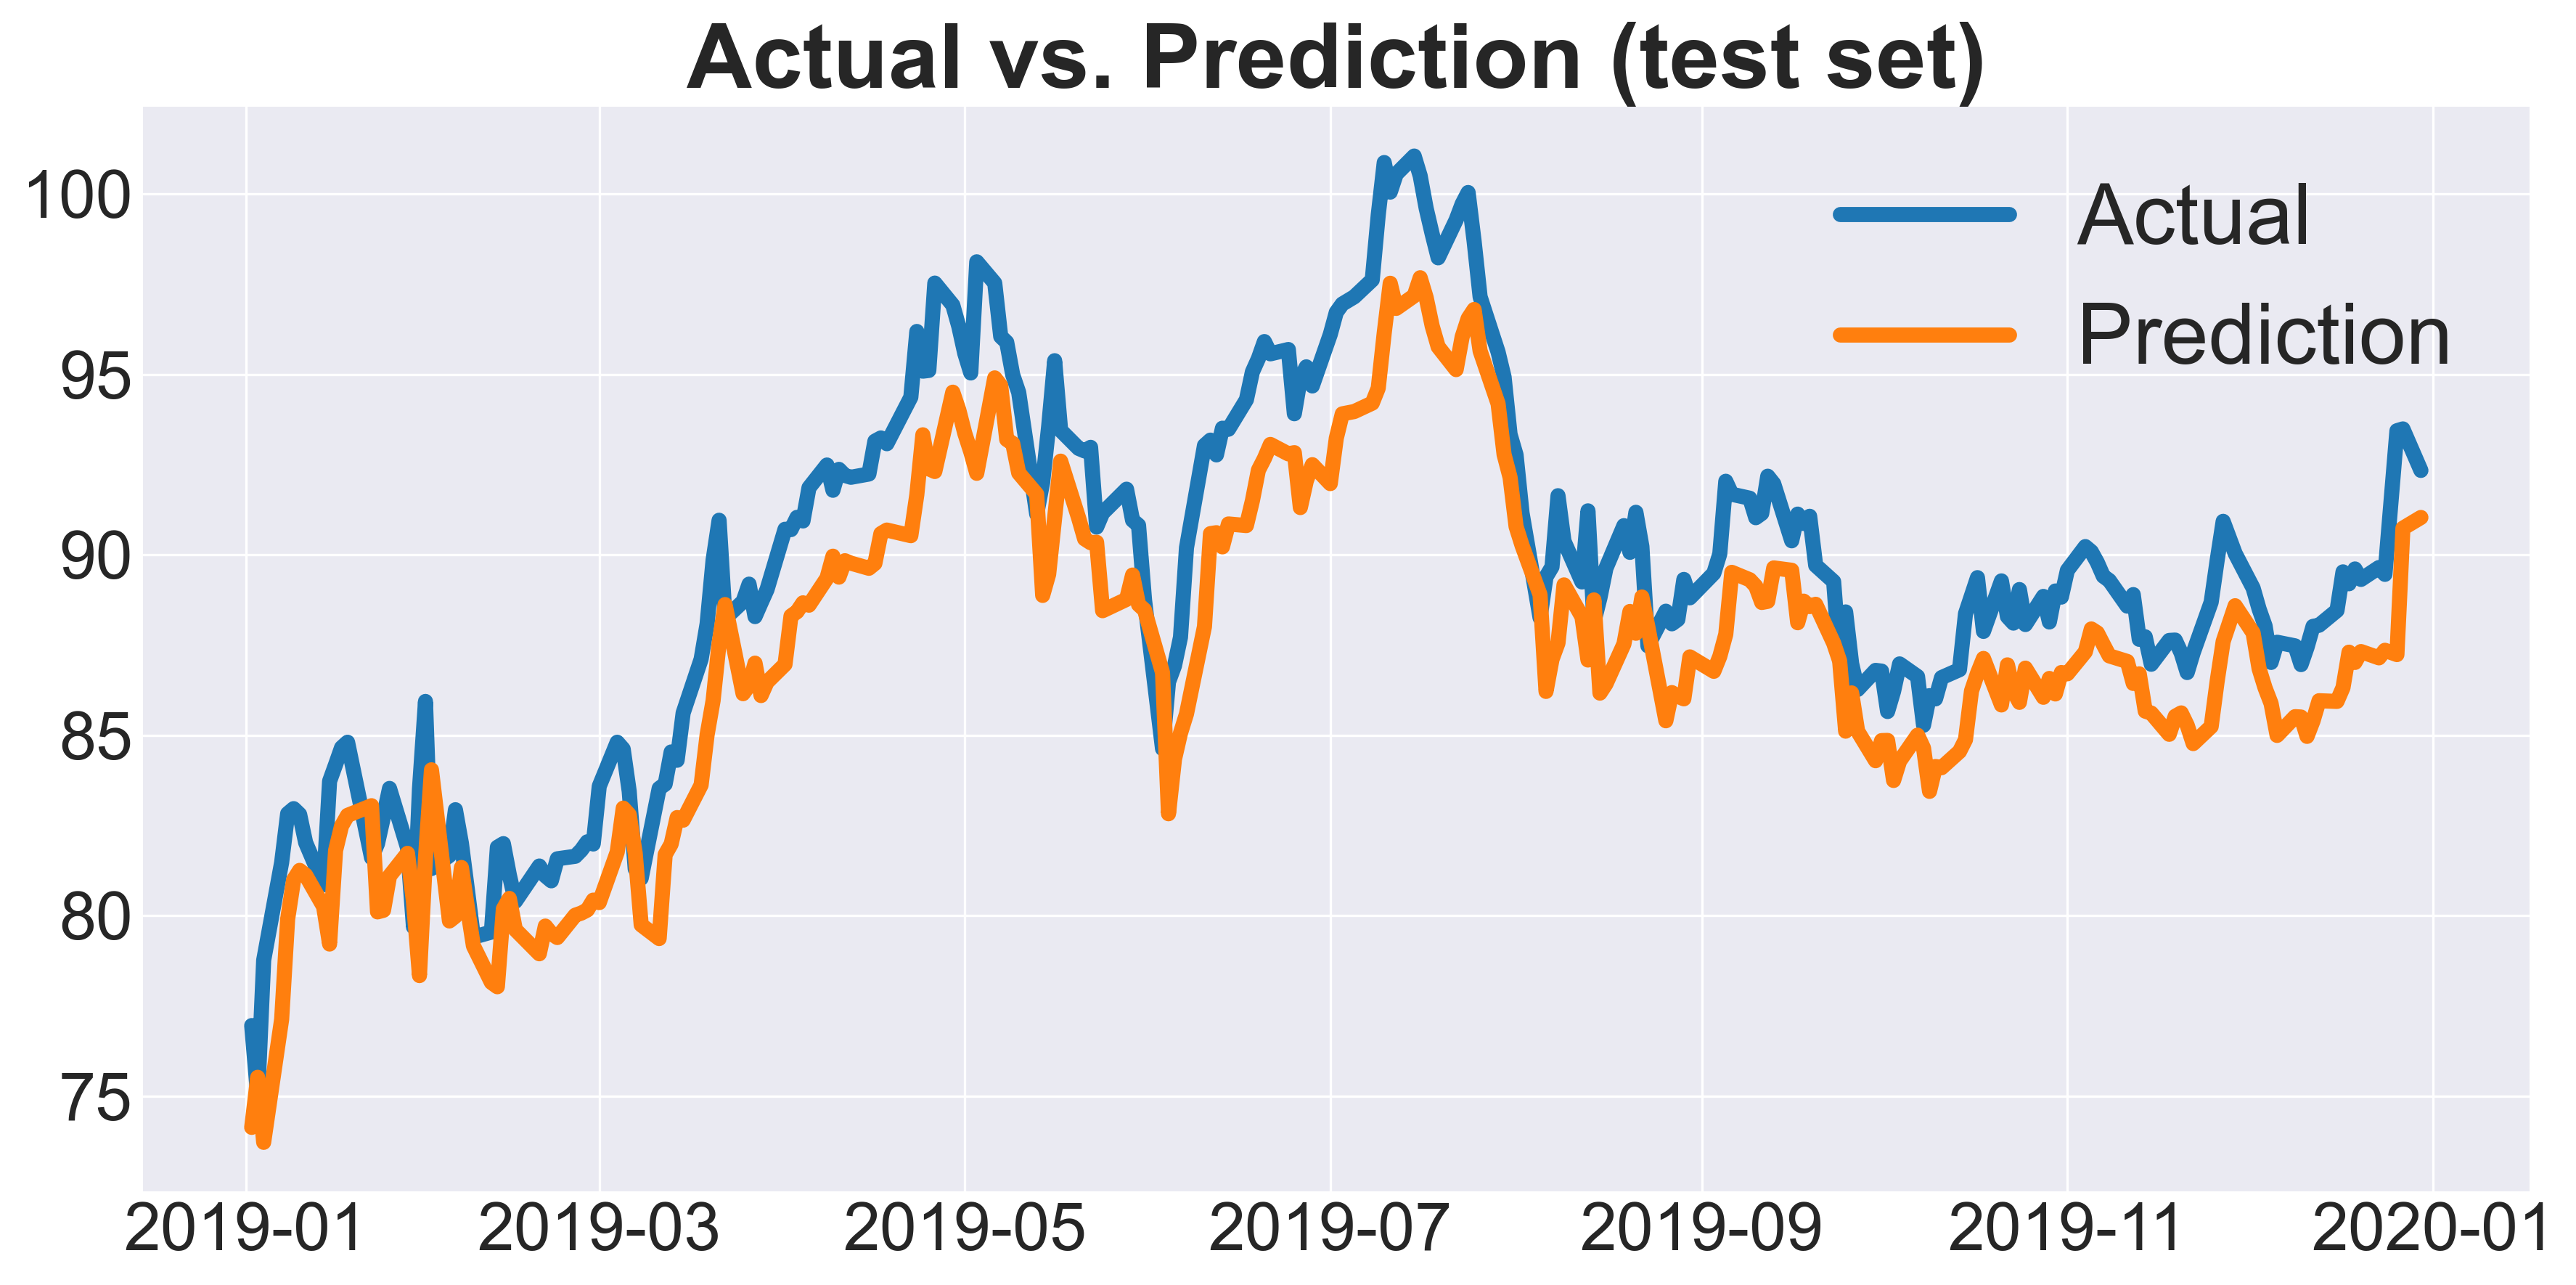

In [21]:
_ = plot_loss_preds(rnn_norm_history, rnn_norm_preds_test)

Now, we have a working model, following the actual trend. Seems like MSE of the validation set is 10x higher than of the training set. That suggests the model might be overfitting. To overcome this, I will add regularization in the form of `Dropout` layers to the model.

## RNN (normalized + regularized)

In [22]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(units=32, activation='tanh', 
                        input_shape=(n_steps, 1)))

rnn_model.add(Dropout(0.1))

rnn_model.add(Dense(units=1)) # Time step of the output

rnn_model.compile(optimizer='rmsprop', 
                  loss='mean_squared_error')

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


8/8 [==============================] - 0s 4ms/step
MSE test: 3.25
MSE validation: 4.7e-04
MSE training: 1.0e-04


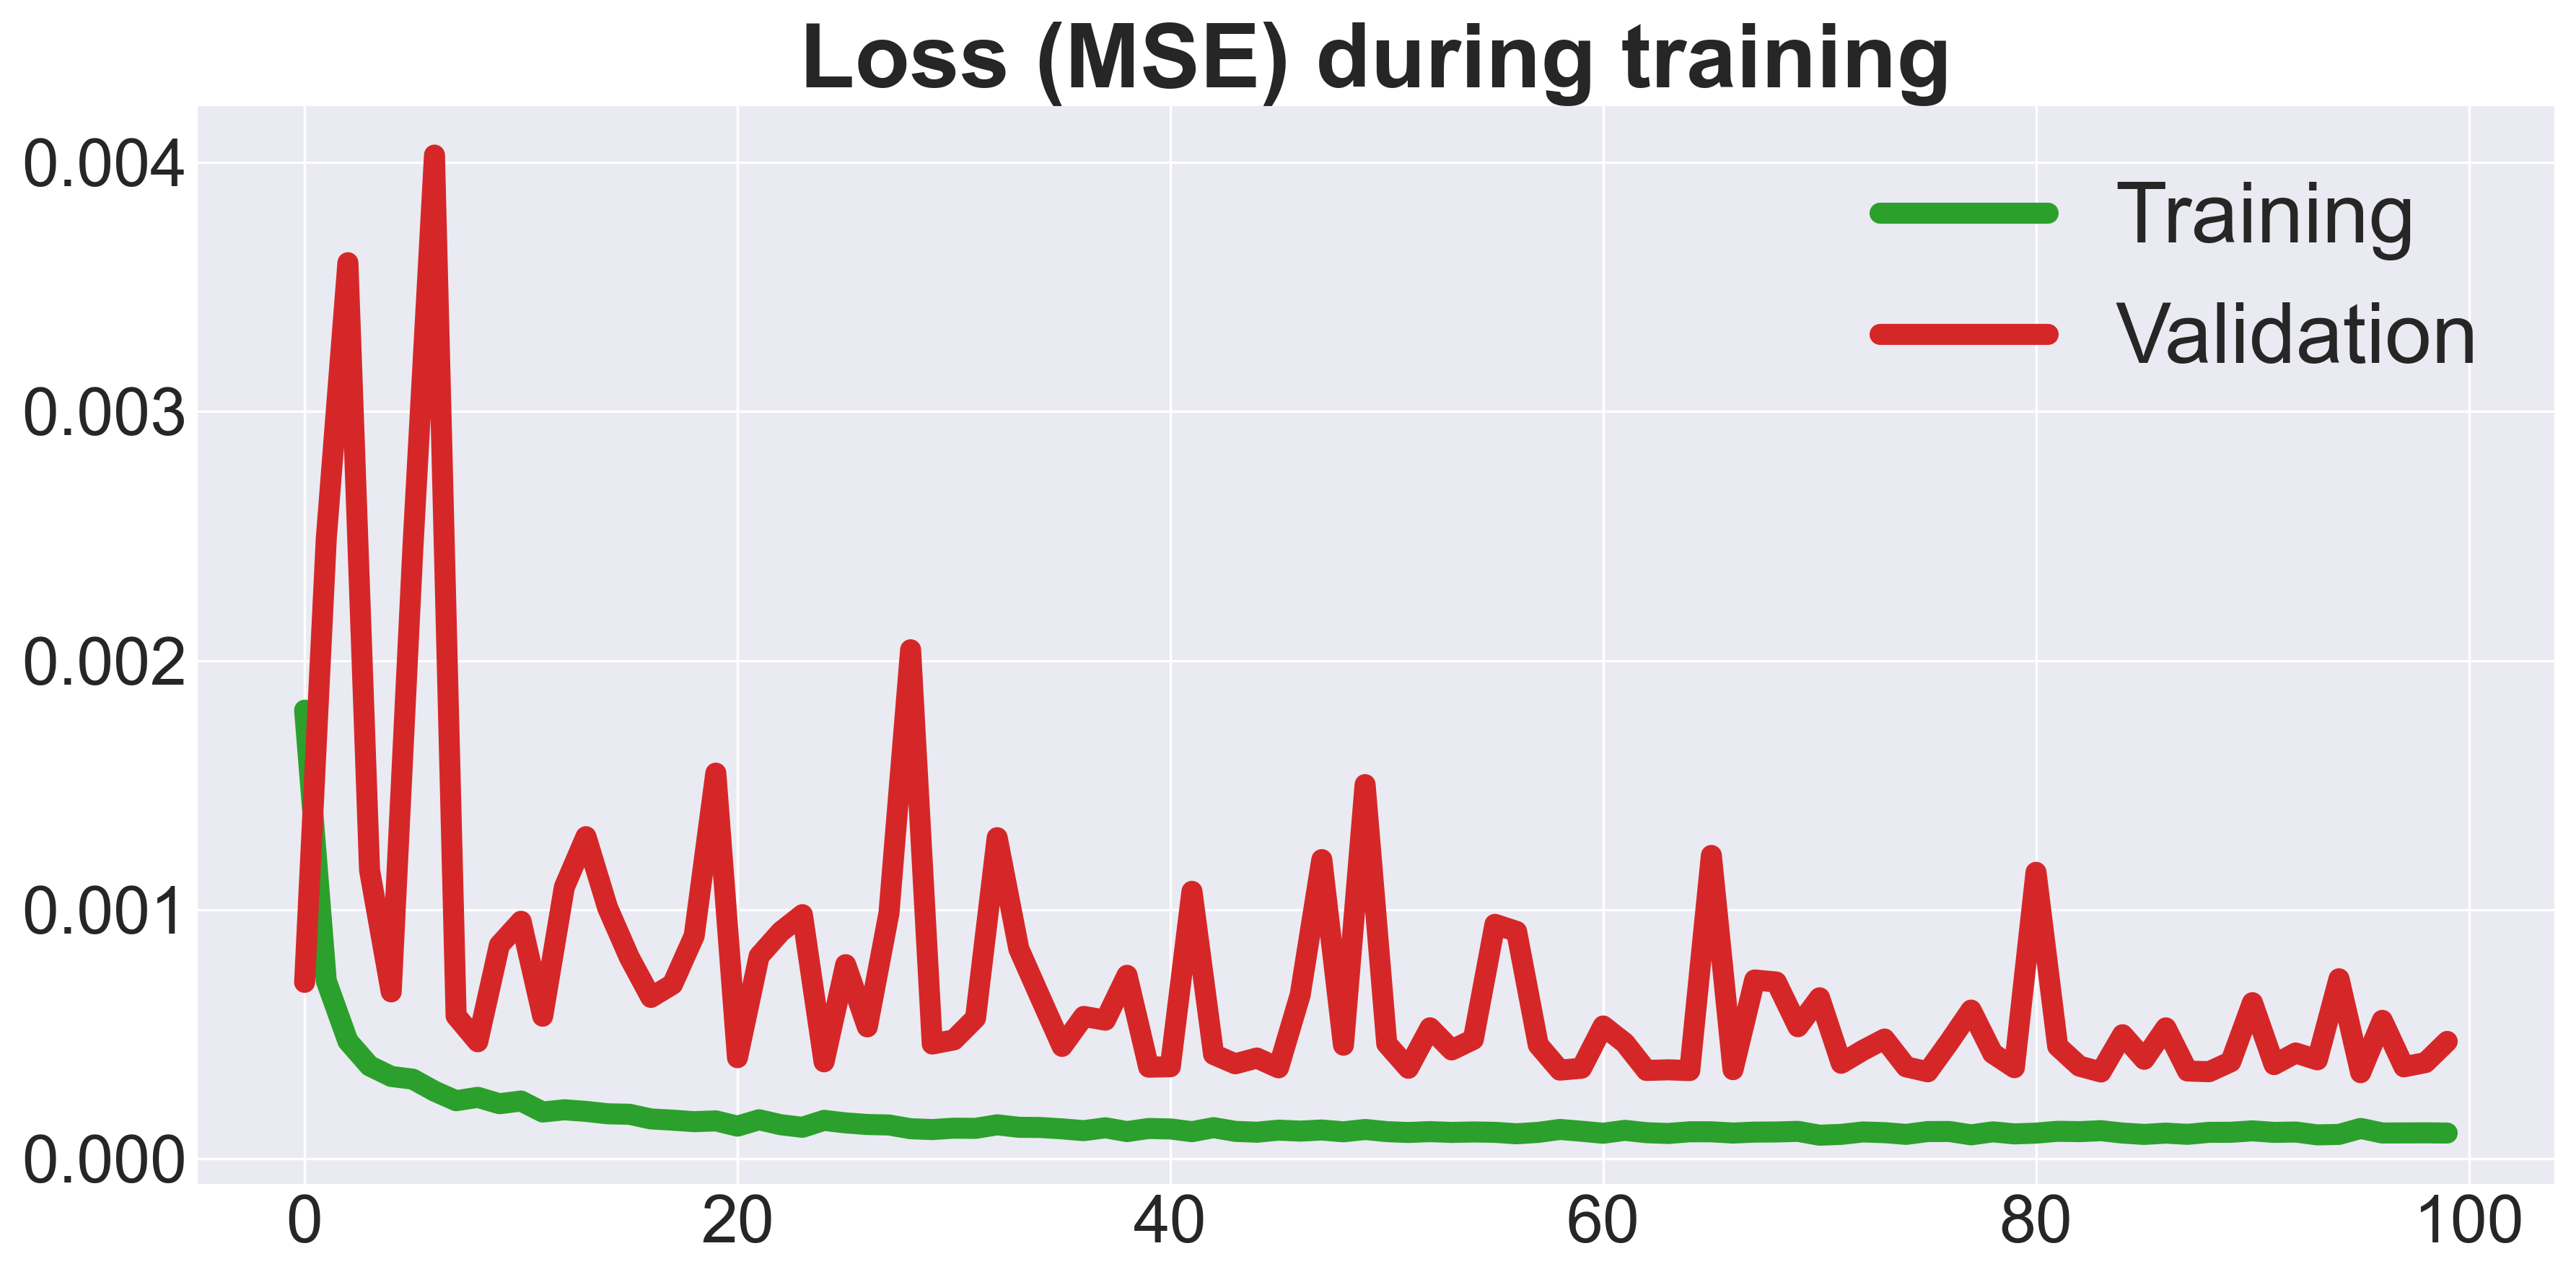

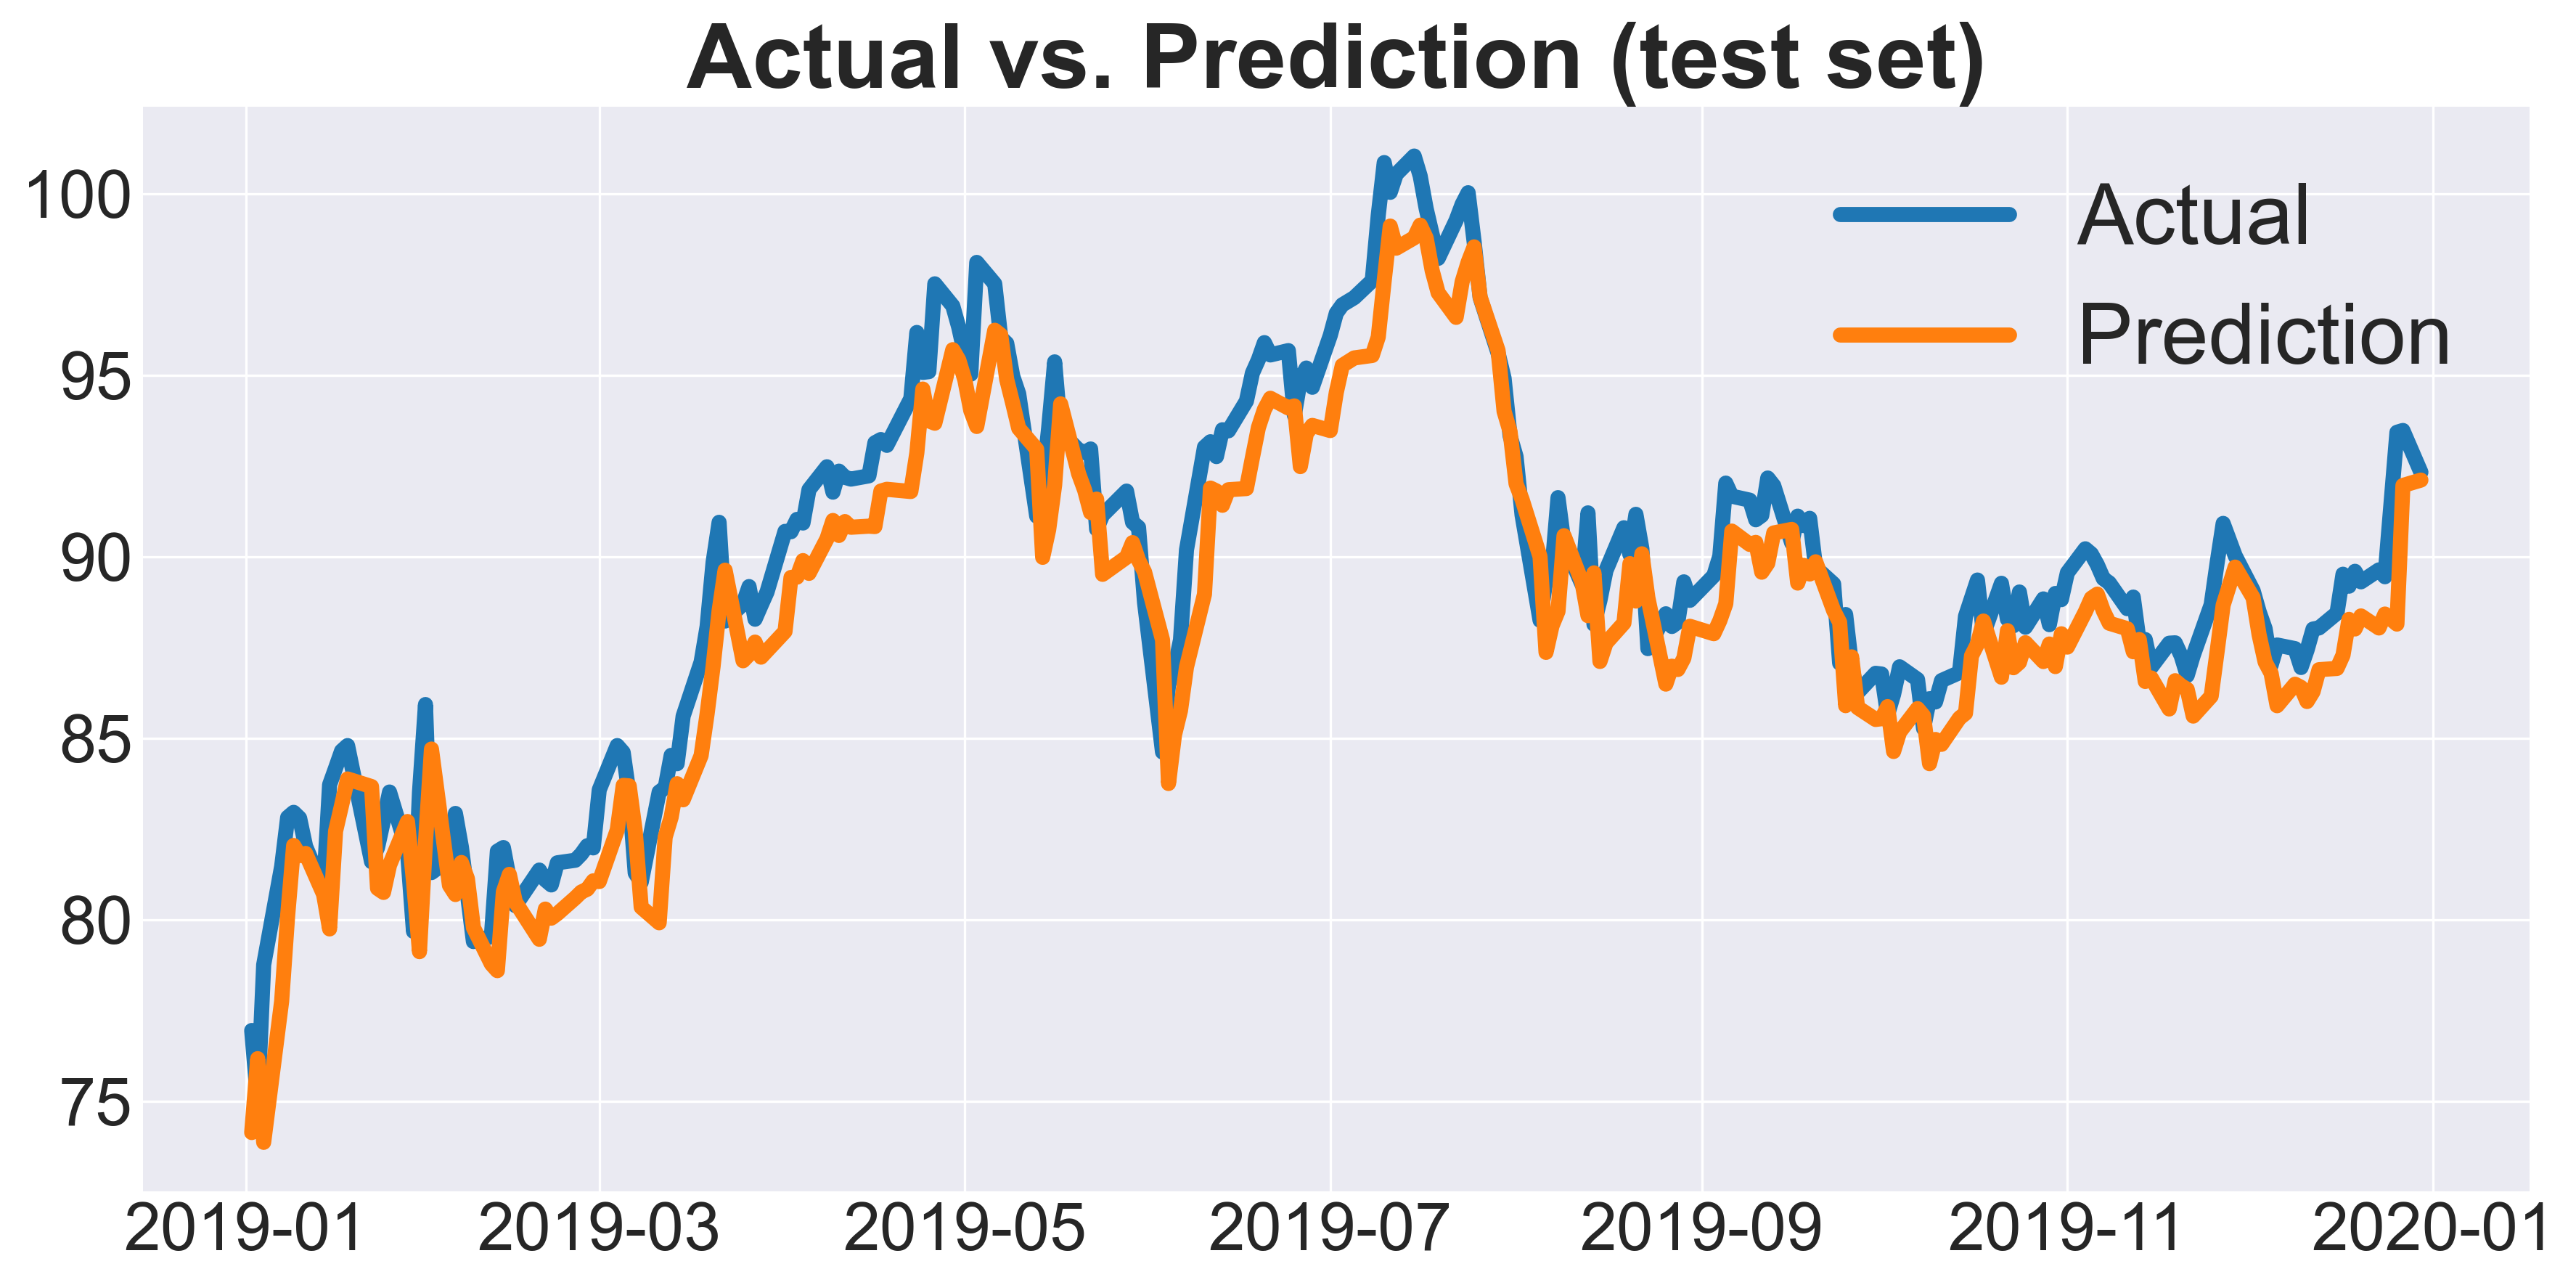

In [23]:
rnn_history = rnn_model.fit(X_train_norm, Y_train_norm, 
                            validation_split= 0.2,
                            epochs=100, 
                            batch_size= 16,
                            verbose= False)

# Predict
rnn_preds_test = predict_print_MSE(rnn_history, scaler)

# Plot loss and prediction
_ = plot_loss_preds(rnn_history, rnn_preds_test)

<u>Comments</u>

- Now, MSE of validation and training set are comprable, suggesting there is no overfitting anymore.

- MSE of test set got significantly lower than unregularized rnn. Seems like regularization made a big difference.

- So far, we have compared the mean-squared error (MSE) of different models. But that is just a relative comparison. Afterall, since MSE is not a metric like percent accuracy, it is a bit hard to tell e.g. if MSE = 2.20 is good enough or not. It would be nice if there was an objective reference point to evaluate our model performance. One way to tell is that, simply, we could guess the next day's stock price just the same as prev day's. This is quite a simple/dummy model but we can use that as a baseline model, some sort of "null hypothesis" for classification problems. Another baseline model alternative: take avg of the last n_step days' to predict the next day's price.

# Baseline/Dummy Model

Dummy model: predict the next day price same as the prev day.

MSE of baseline model: 1.60


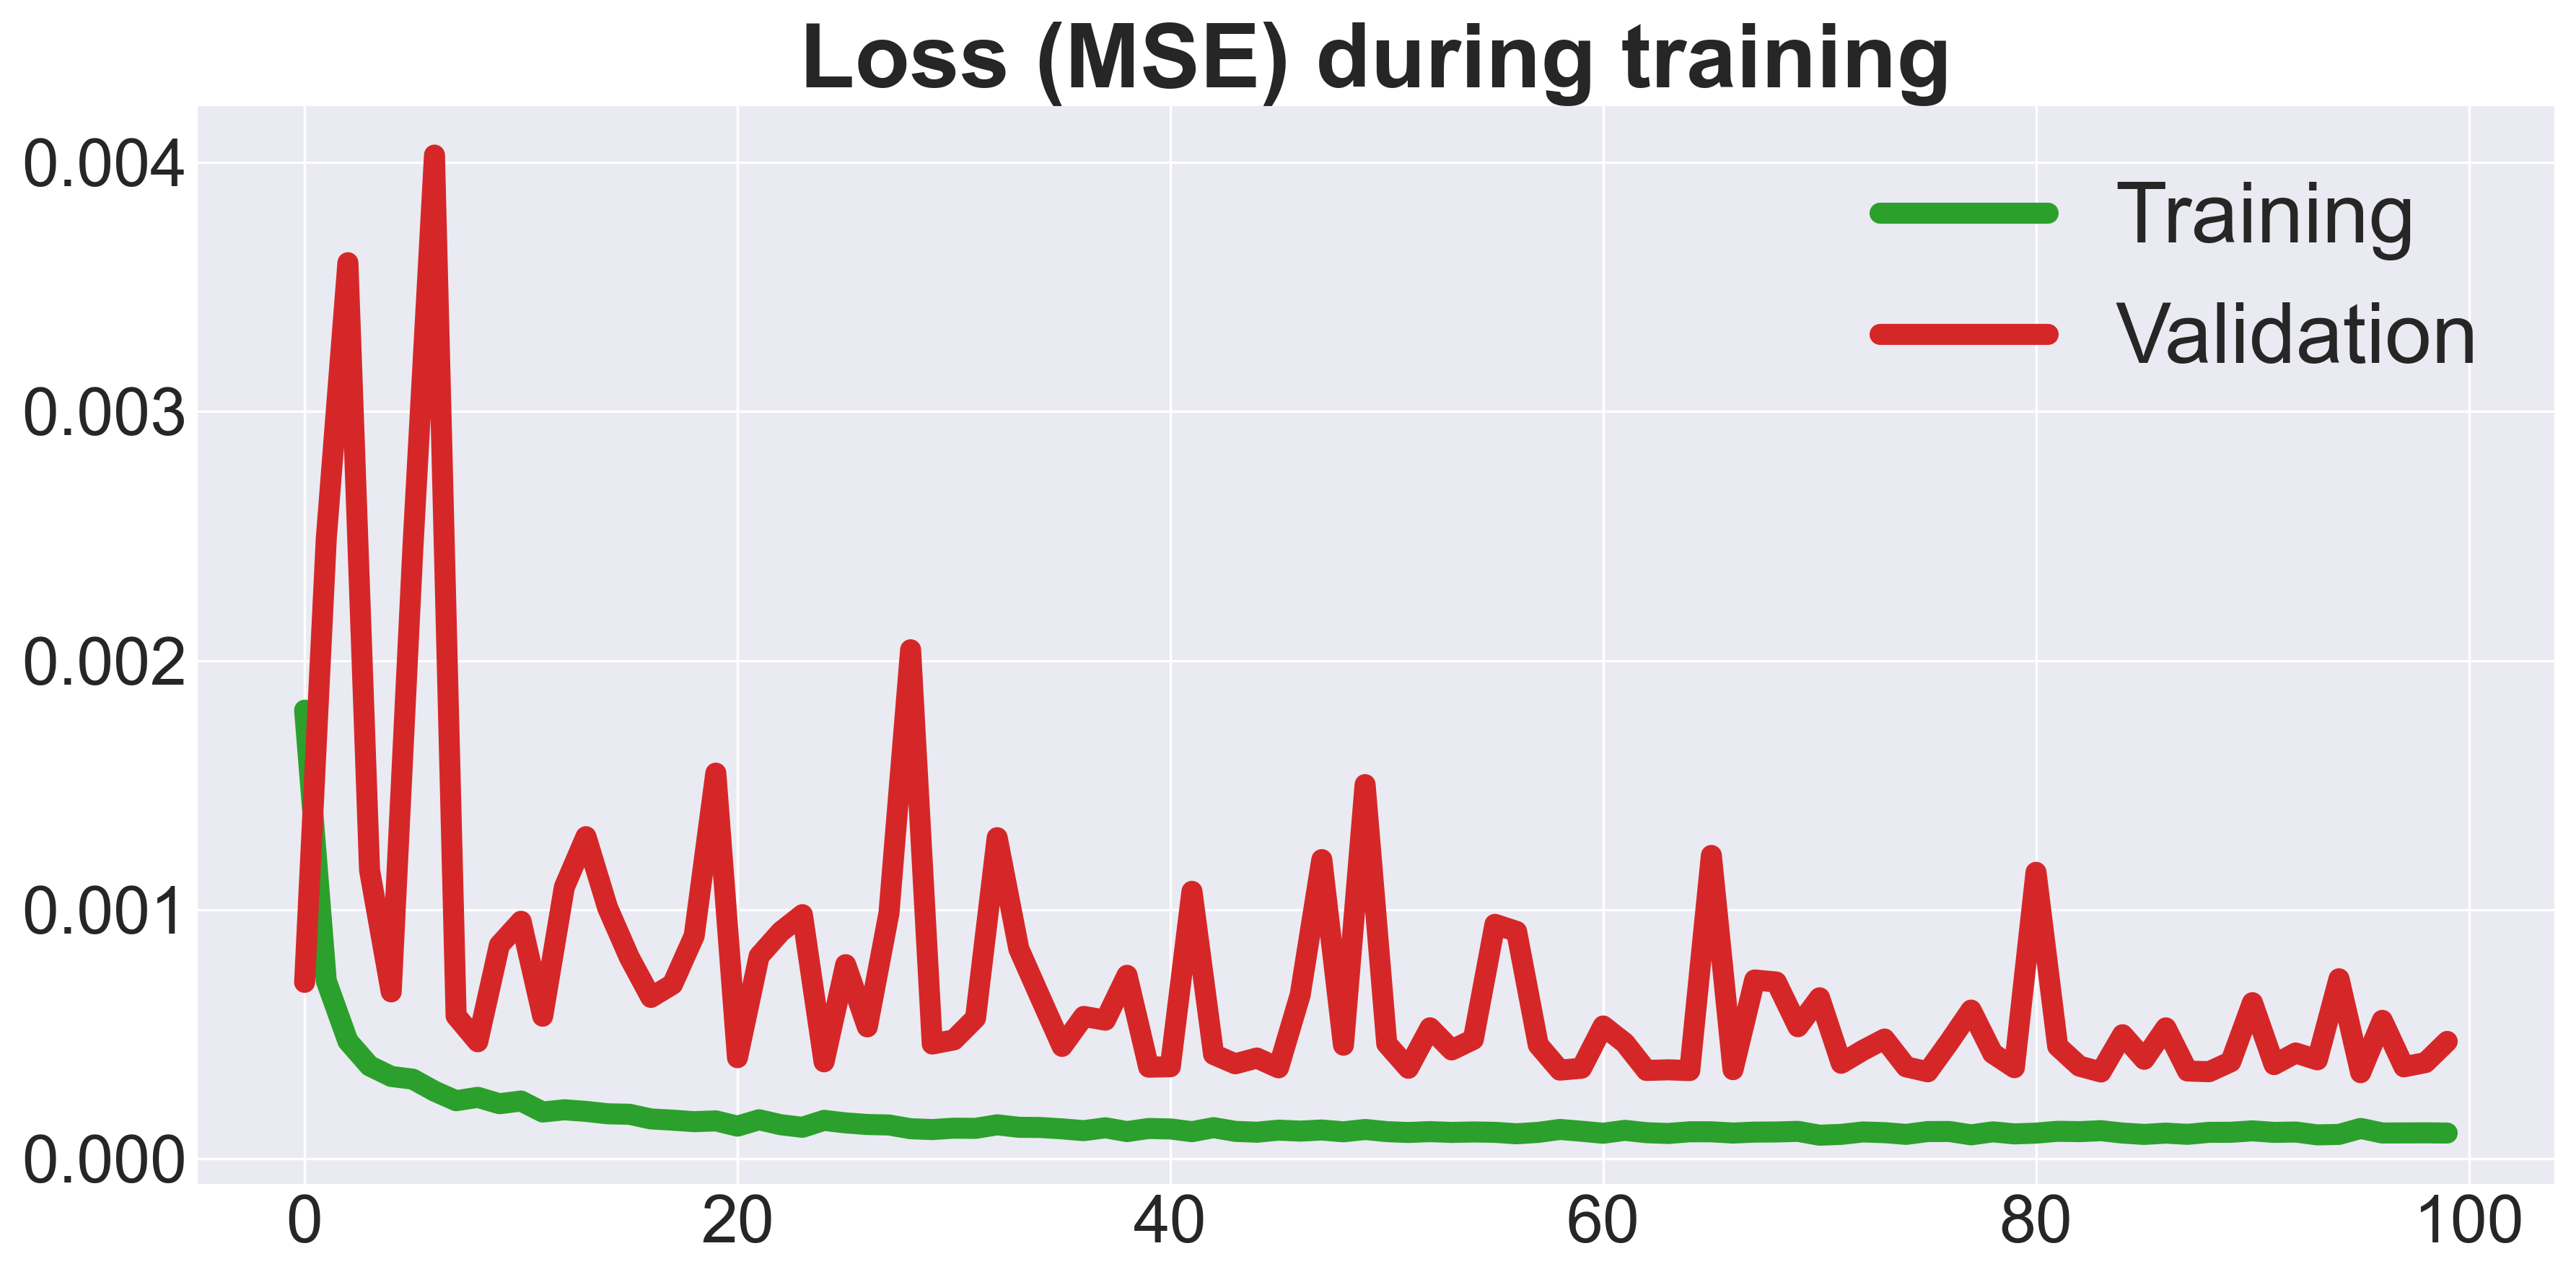

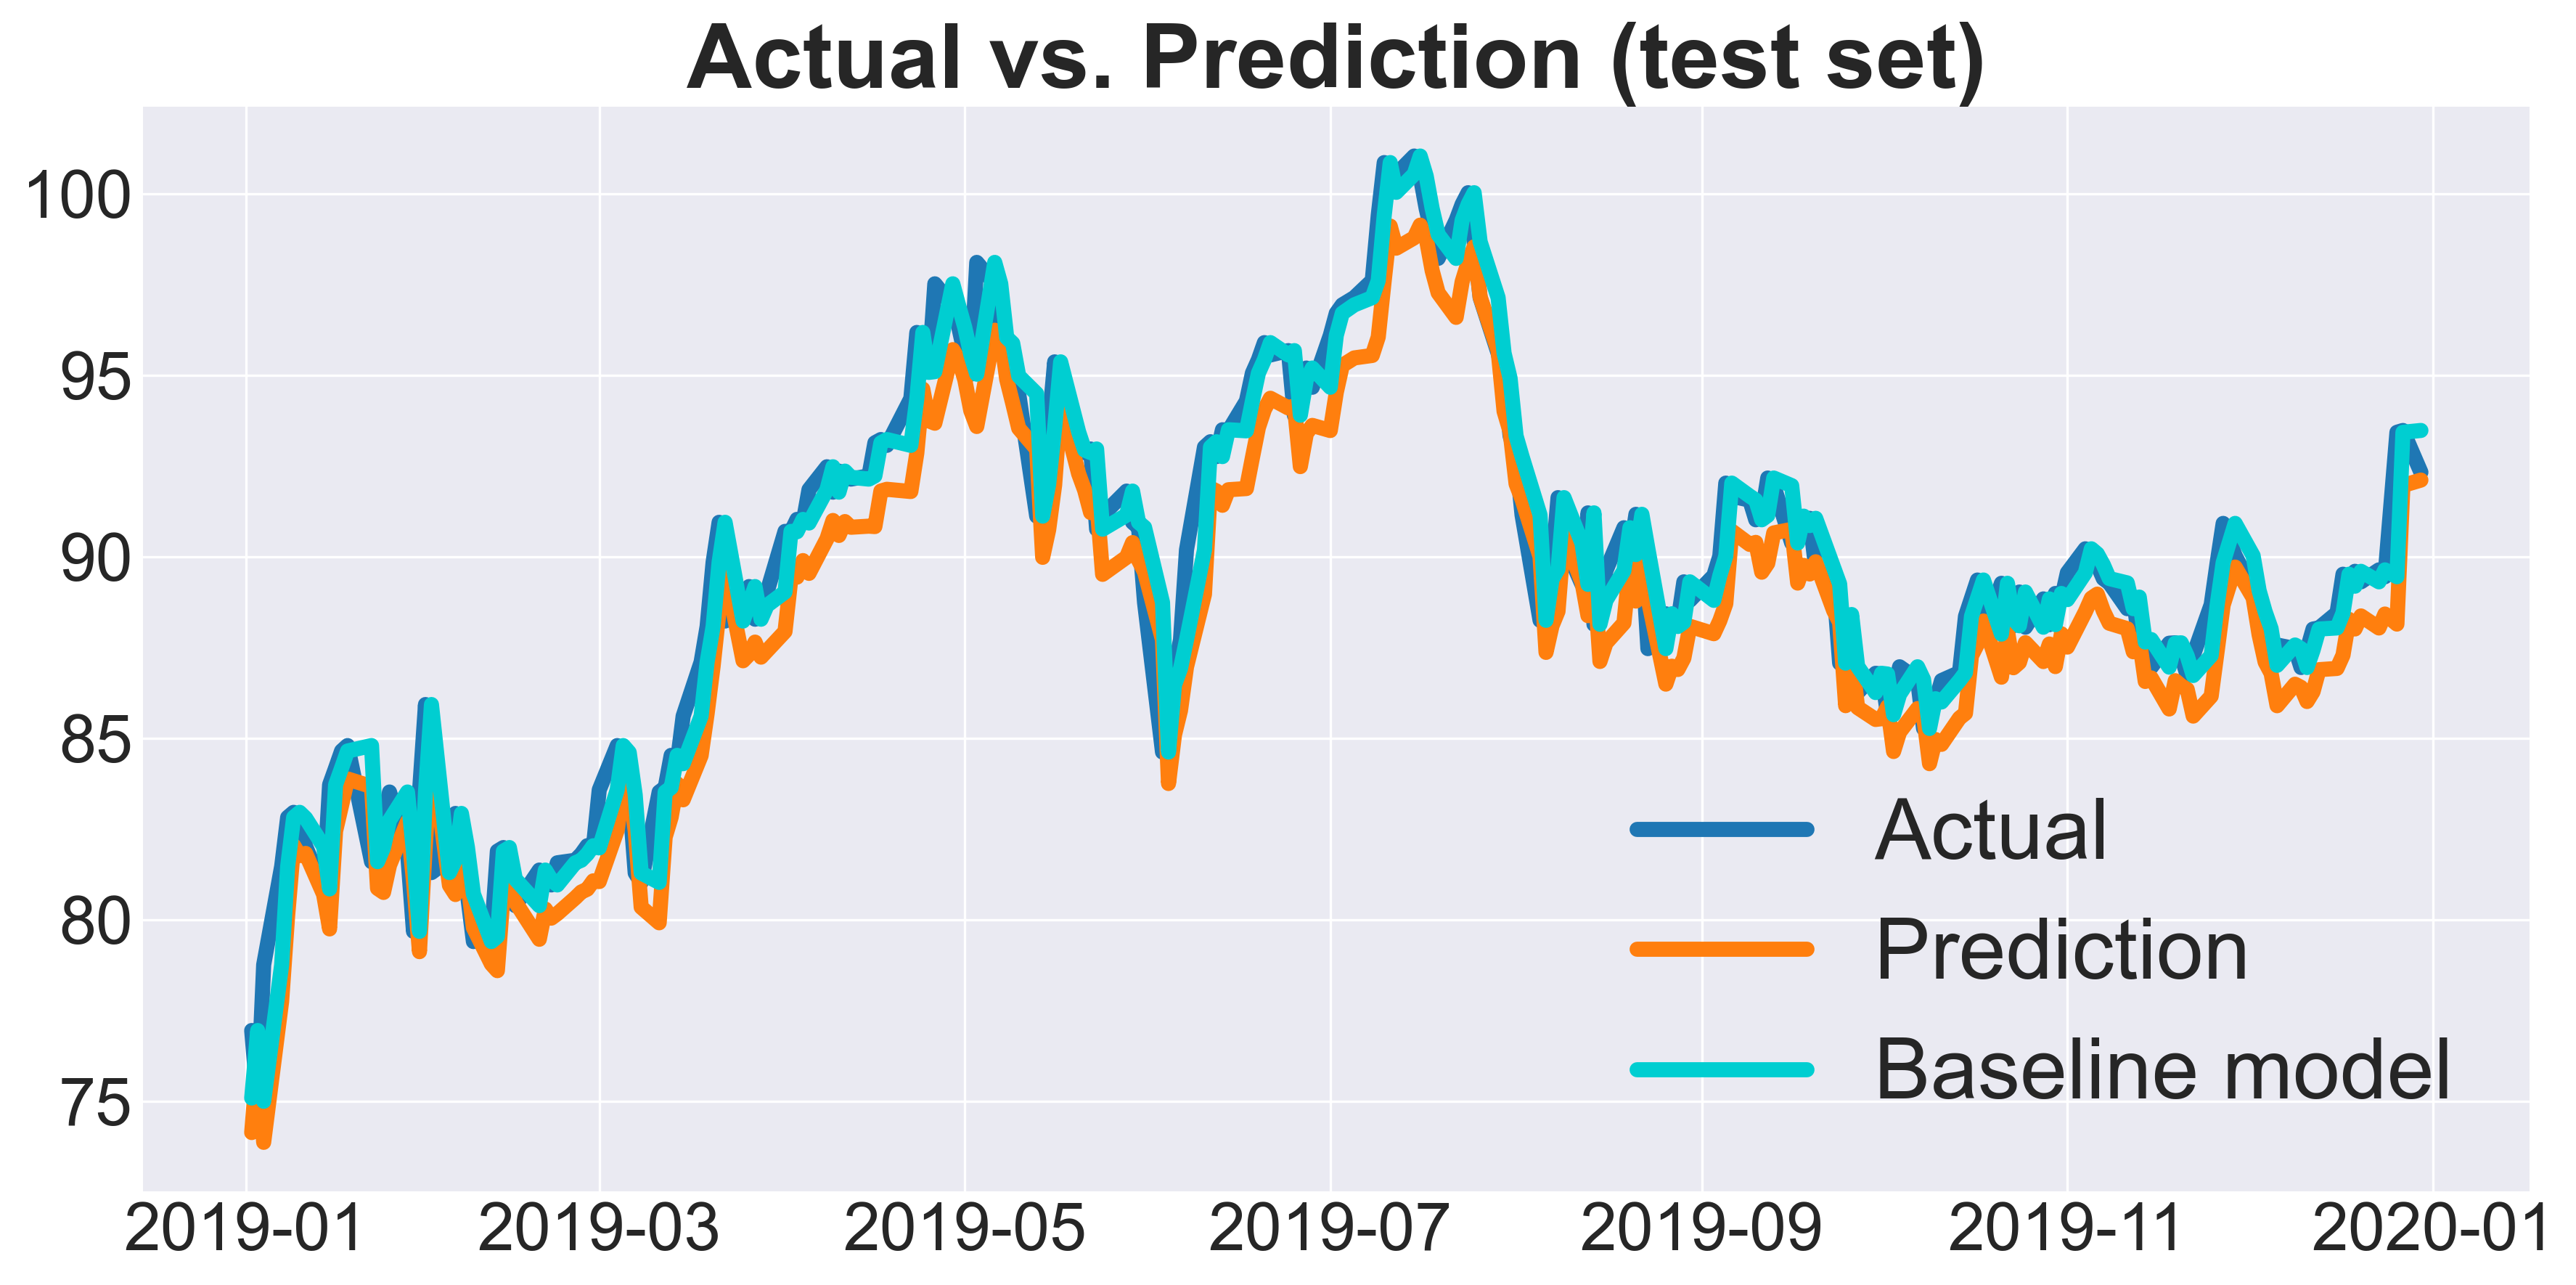

In [24]:
baseline_preds_test = X_test[:, -1, 0] 
baseline_preds_test = baseline_preds_test.reshape(-1,1)

# Create df for baseline preds sharing the same index as of all_data
df_baseline = pd.DataFrame(index = all_data['2019':].index,
                           data = {'Adj Close':baseline_preds_test[:,0]})

mse_dummy = MeanSquaredError()(Y_test, baseline_preds_test).numpy()
print (f'MSE of baseline model: {mse_dummy:.2f}')

# Plot the baseline prediction on top of the last rnn model 
ax1, ax2 = plot_loss_preds(rnn_history, rnn_preds_test)

# good colors: lightskyblue, darkturquoise, tab:red
ax2.plot(df_baseline['Adj Close'], 
         label='Baseline model', lw=5,
         color='darkturquoise')

_ = ax2.legend(fontsize=28)

MSE of the dummy model is 1.60 which is comparable to the MSE of the regularized normalized rnn model. That means our model does not go beyond the dummy model. This is also evident from the plot above: cyan colored baseline curve almost perfectly overlaps with the orange prediction curve. 

Let's try some other neural network units, LSTM and GRU, to see if they perform better than RNN.

# LSTM

I will implement LSTM model with regularization on the normalized data. 

In [25]:
lstm_model = Sequential()

# Only one LSTM layer
lstm_model.add(LSTM(units=32, activation='tanh', 
                    input_shape=(n_steps, 1)))

lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=1)) # Time step of the output

lstm_model.compile(optimizer='rmsprop', 
                   loss='mean_squared_error')
# lstm_model.compile(optimizer=SGD(learning_rate=0.01, ), 
#                    loss='mean_squared_error')

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


8/8 [==============================] - 1s 4ms/step
MSE test: 3.24
MSE validation: 6.1e-04
MSE training: 2.0e-04


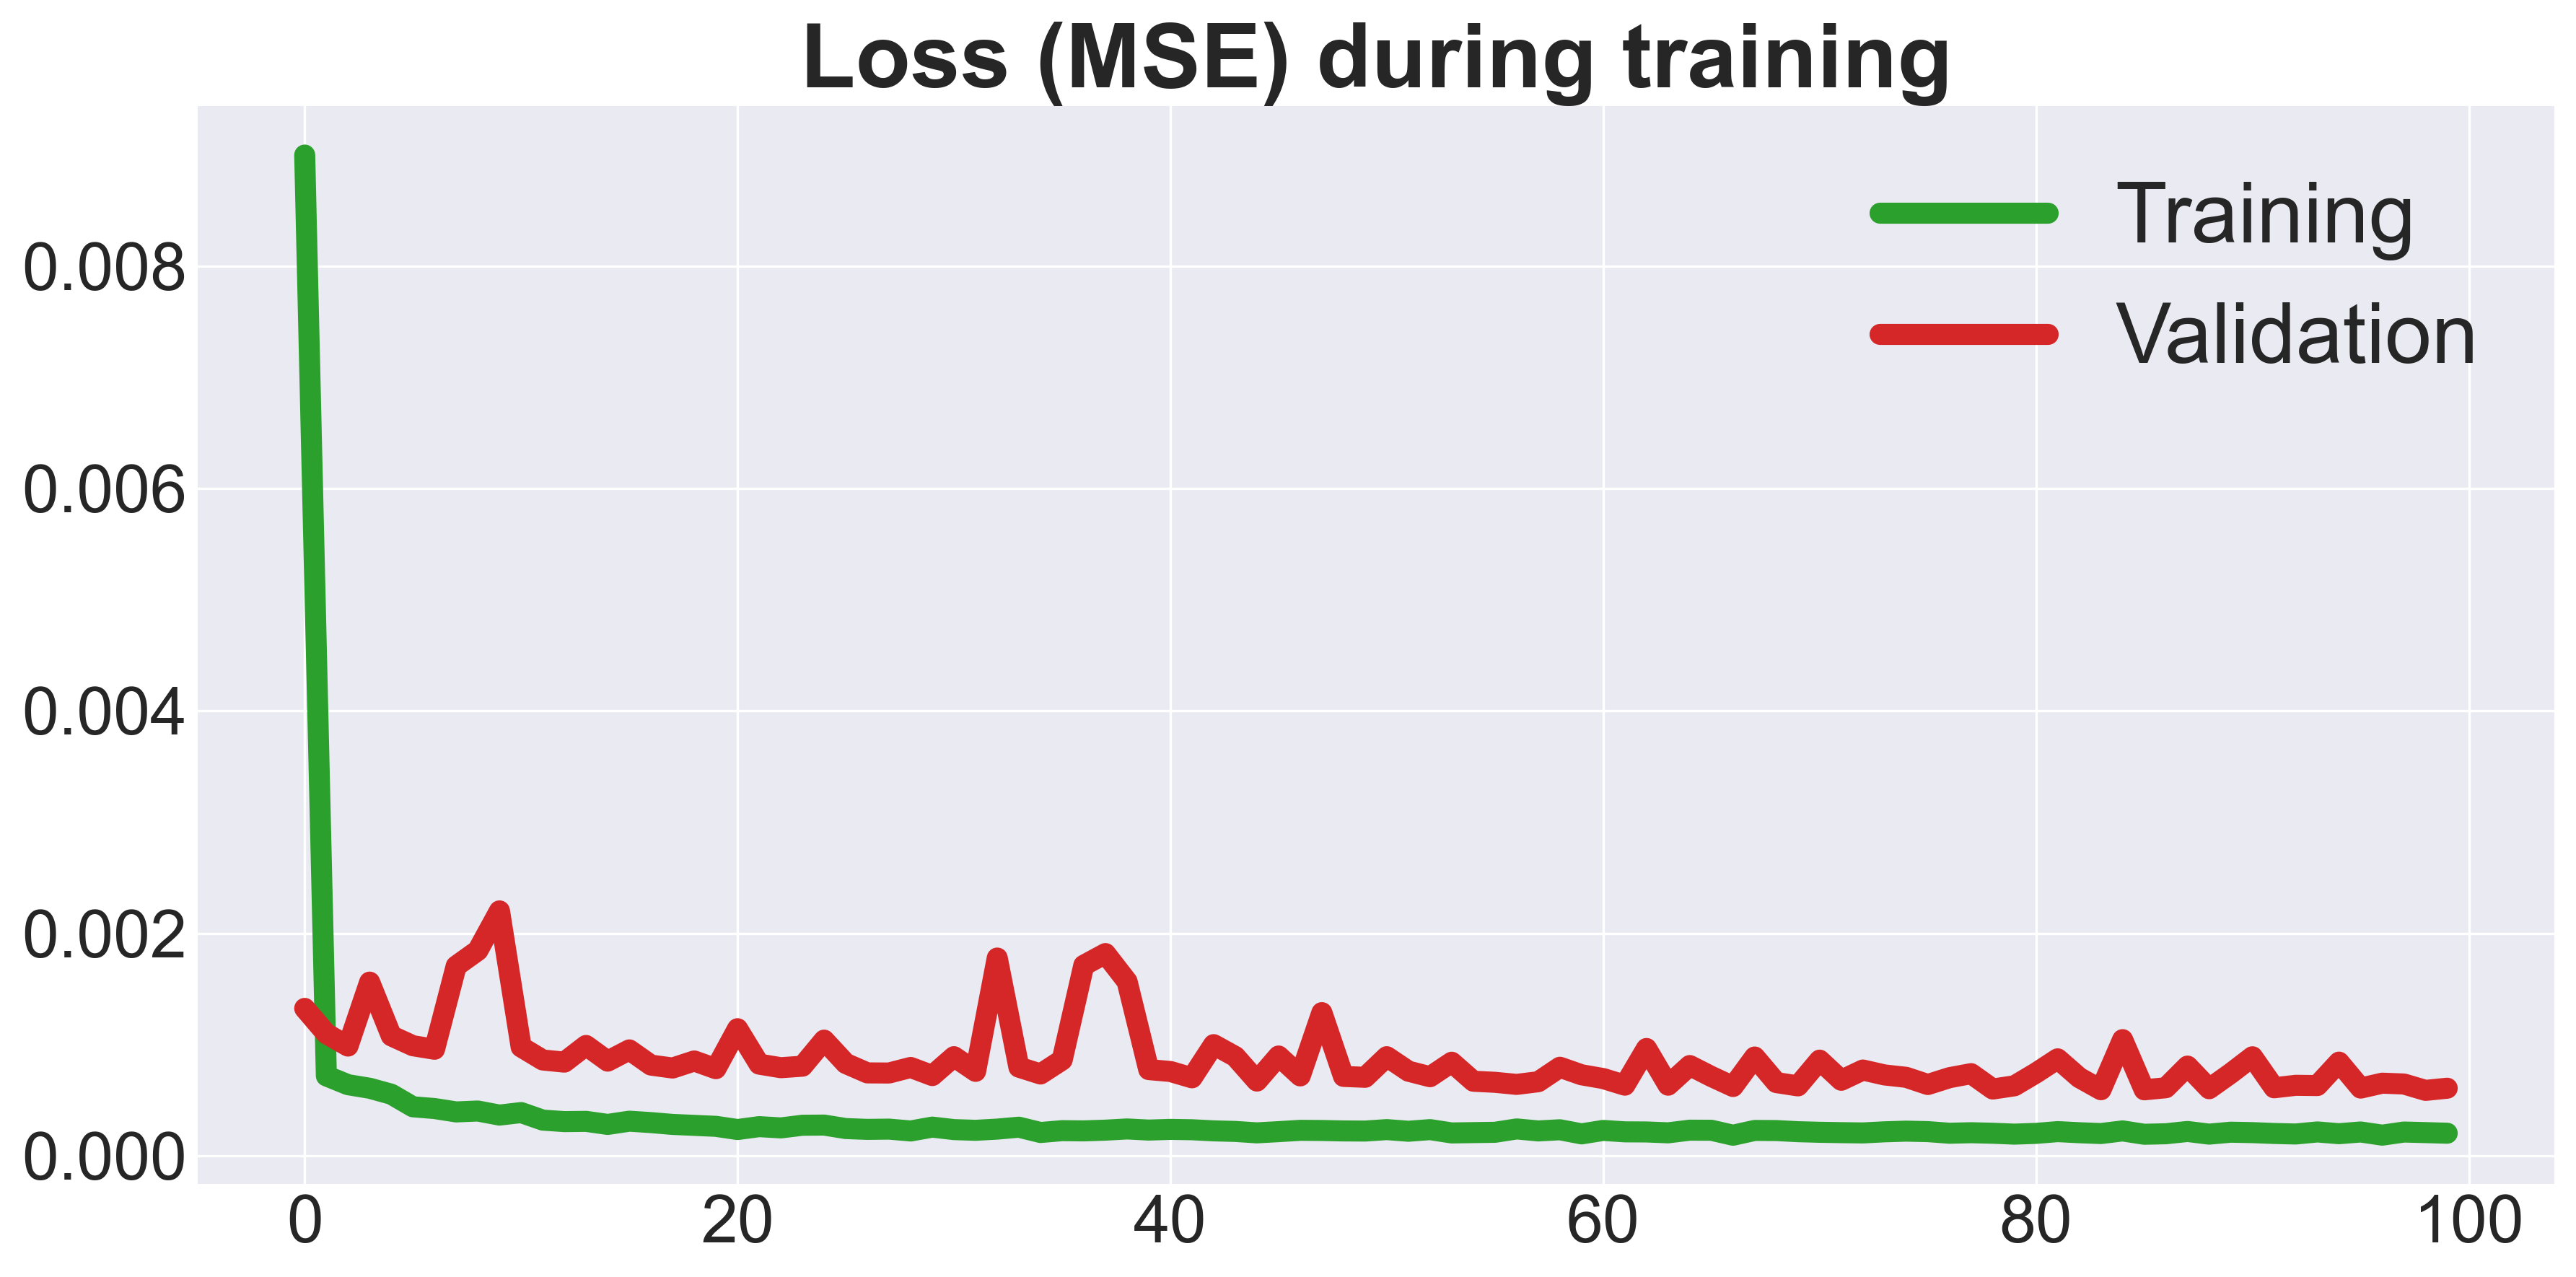

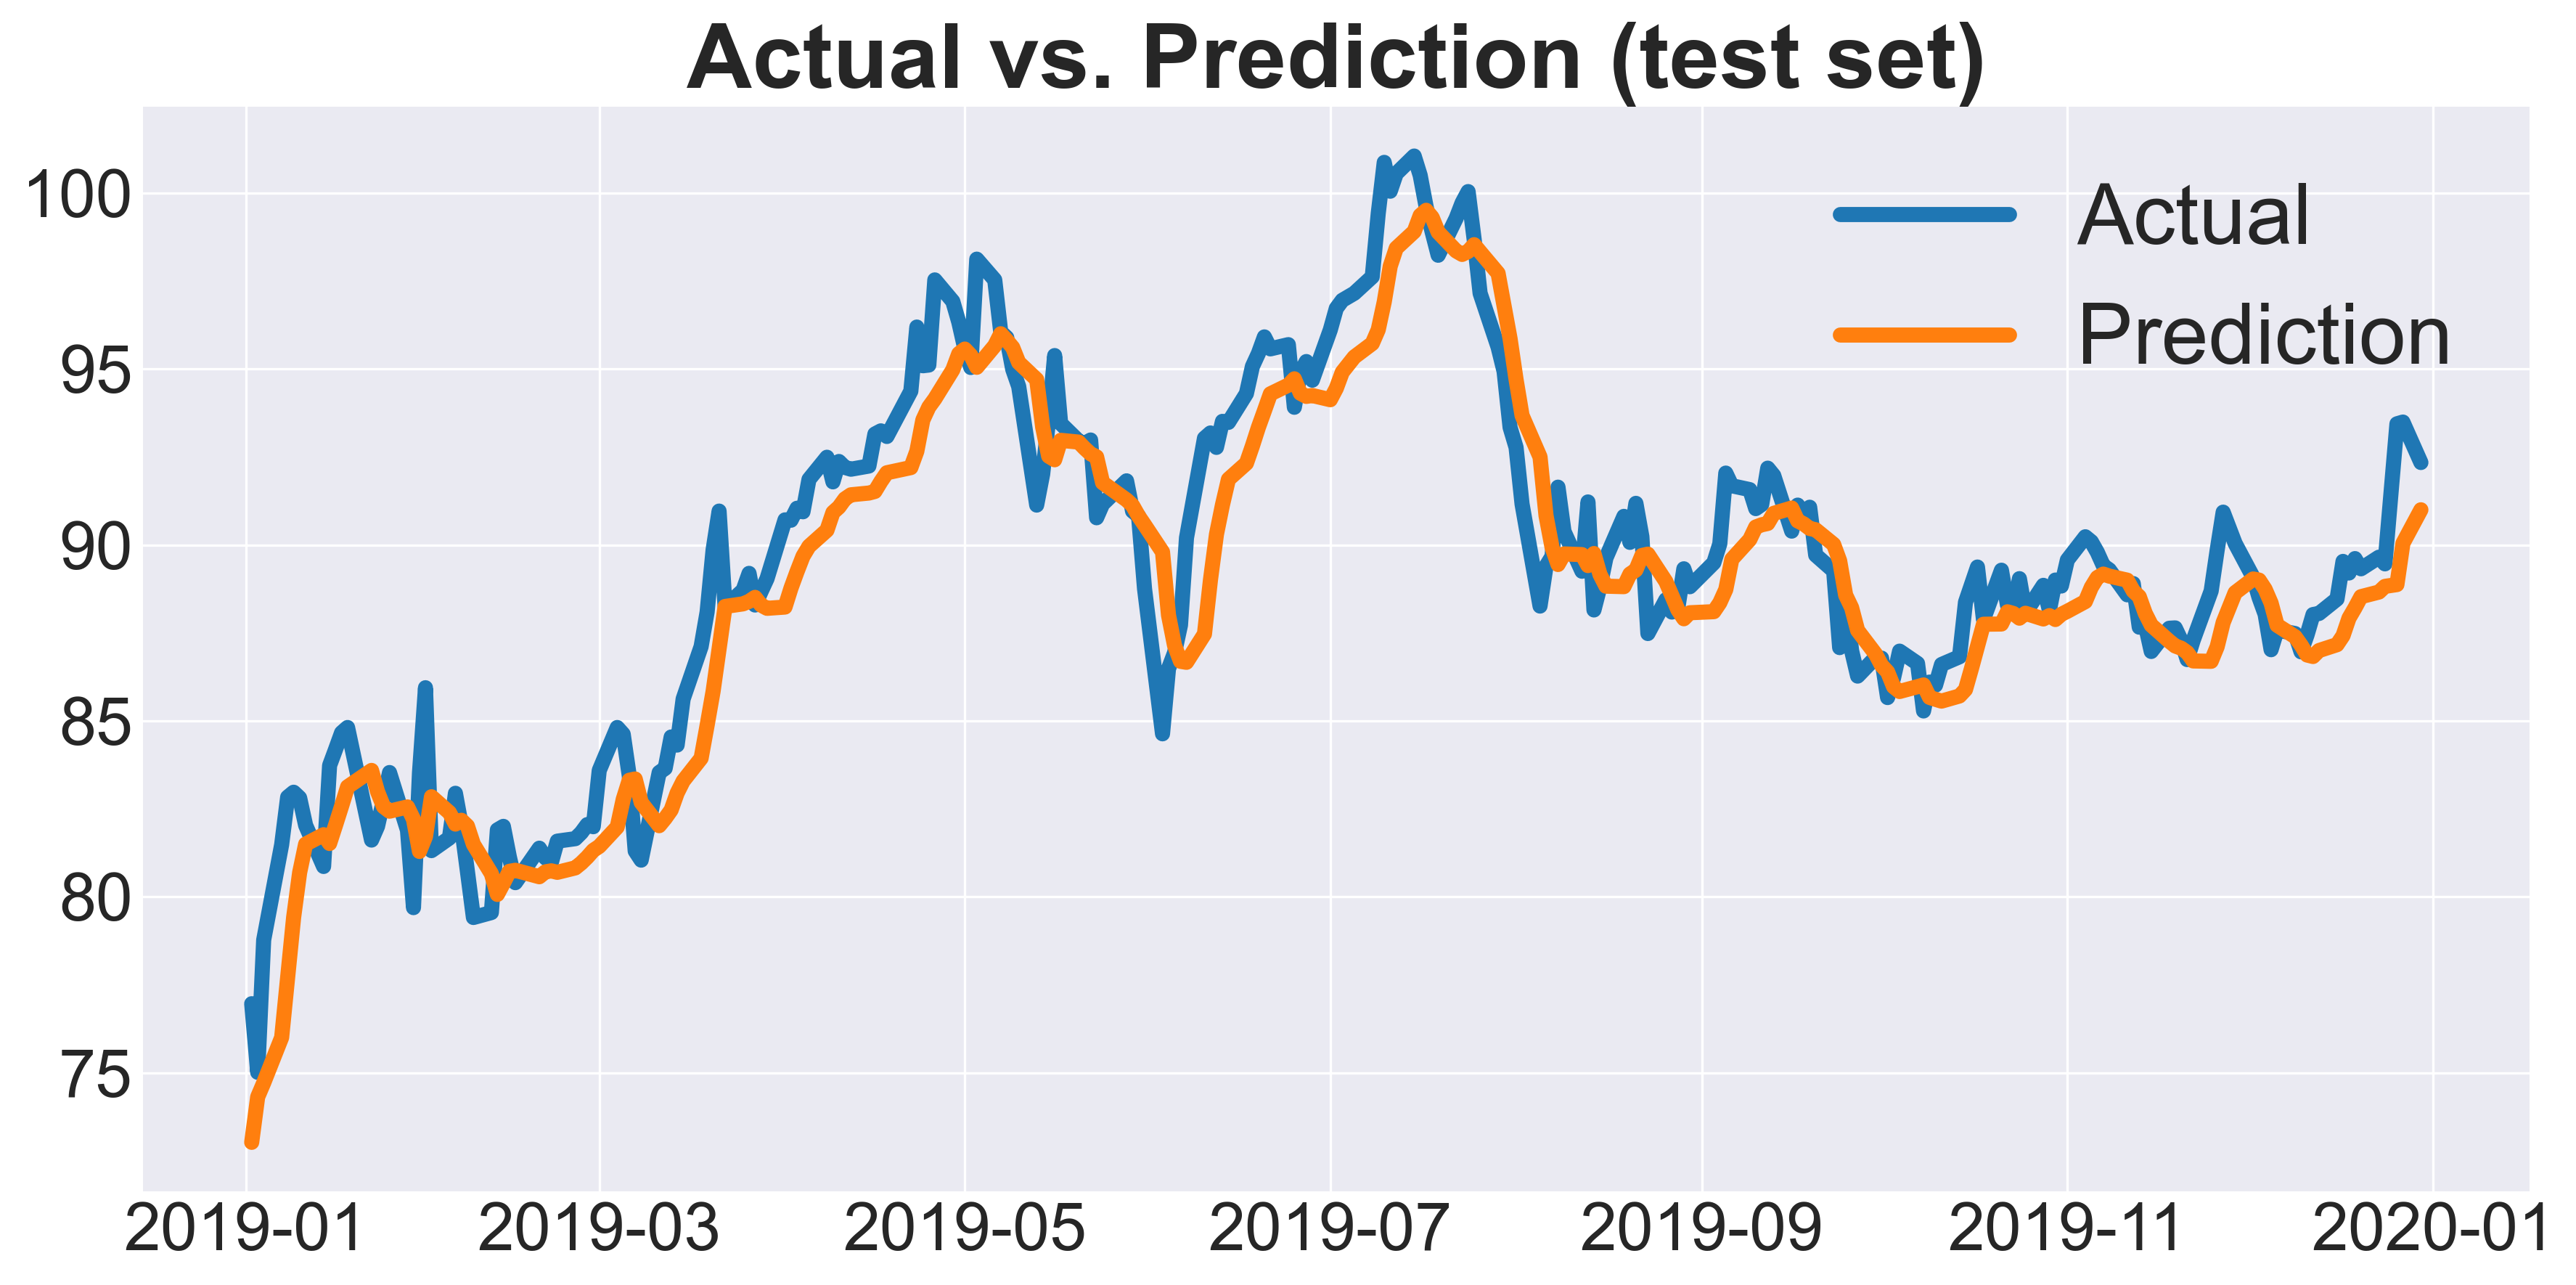

In [26]:
lstm_history = lstm_model.fit(X_train_norm, Y_train_norm, 
                              validation_split=0.2, 
                              epochs=100, 
                              batch_size=16, 
                              verbose=False)

# Predict
lstm_preds_test = predict_print_MSE(lstm_history, scaler)

# Plot loss and prediction
_ = plot_loss_preds(lstm_history, lstm_preds_test)

Comparable to regularized & normalized RNN model. 

# GRU

In [32]:
gru_model = Sequential()

gru_model.add(GRU(units=32, activation='tanh', 
                  input_shape=(n_steps, 1)))

gru_model.add(Dropout(0.1))

gru_model.add(Dense(units=1)) # Time step of the output

gru_model.compile(optimizer='rmsprop', 
                  loss='mean_squared_error')

gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                3360      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3393 (13.25 KB)
Trainable params: 3393 (13.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


8/8 [==============================] - 1s 4ms/step
MSE test: 2.17
MSE validation: 4.2e-04
MSE training: 1.2e-04


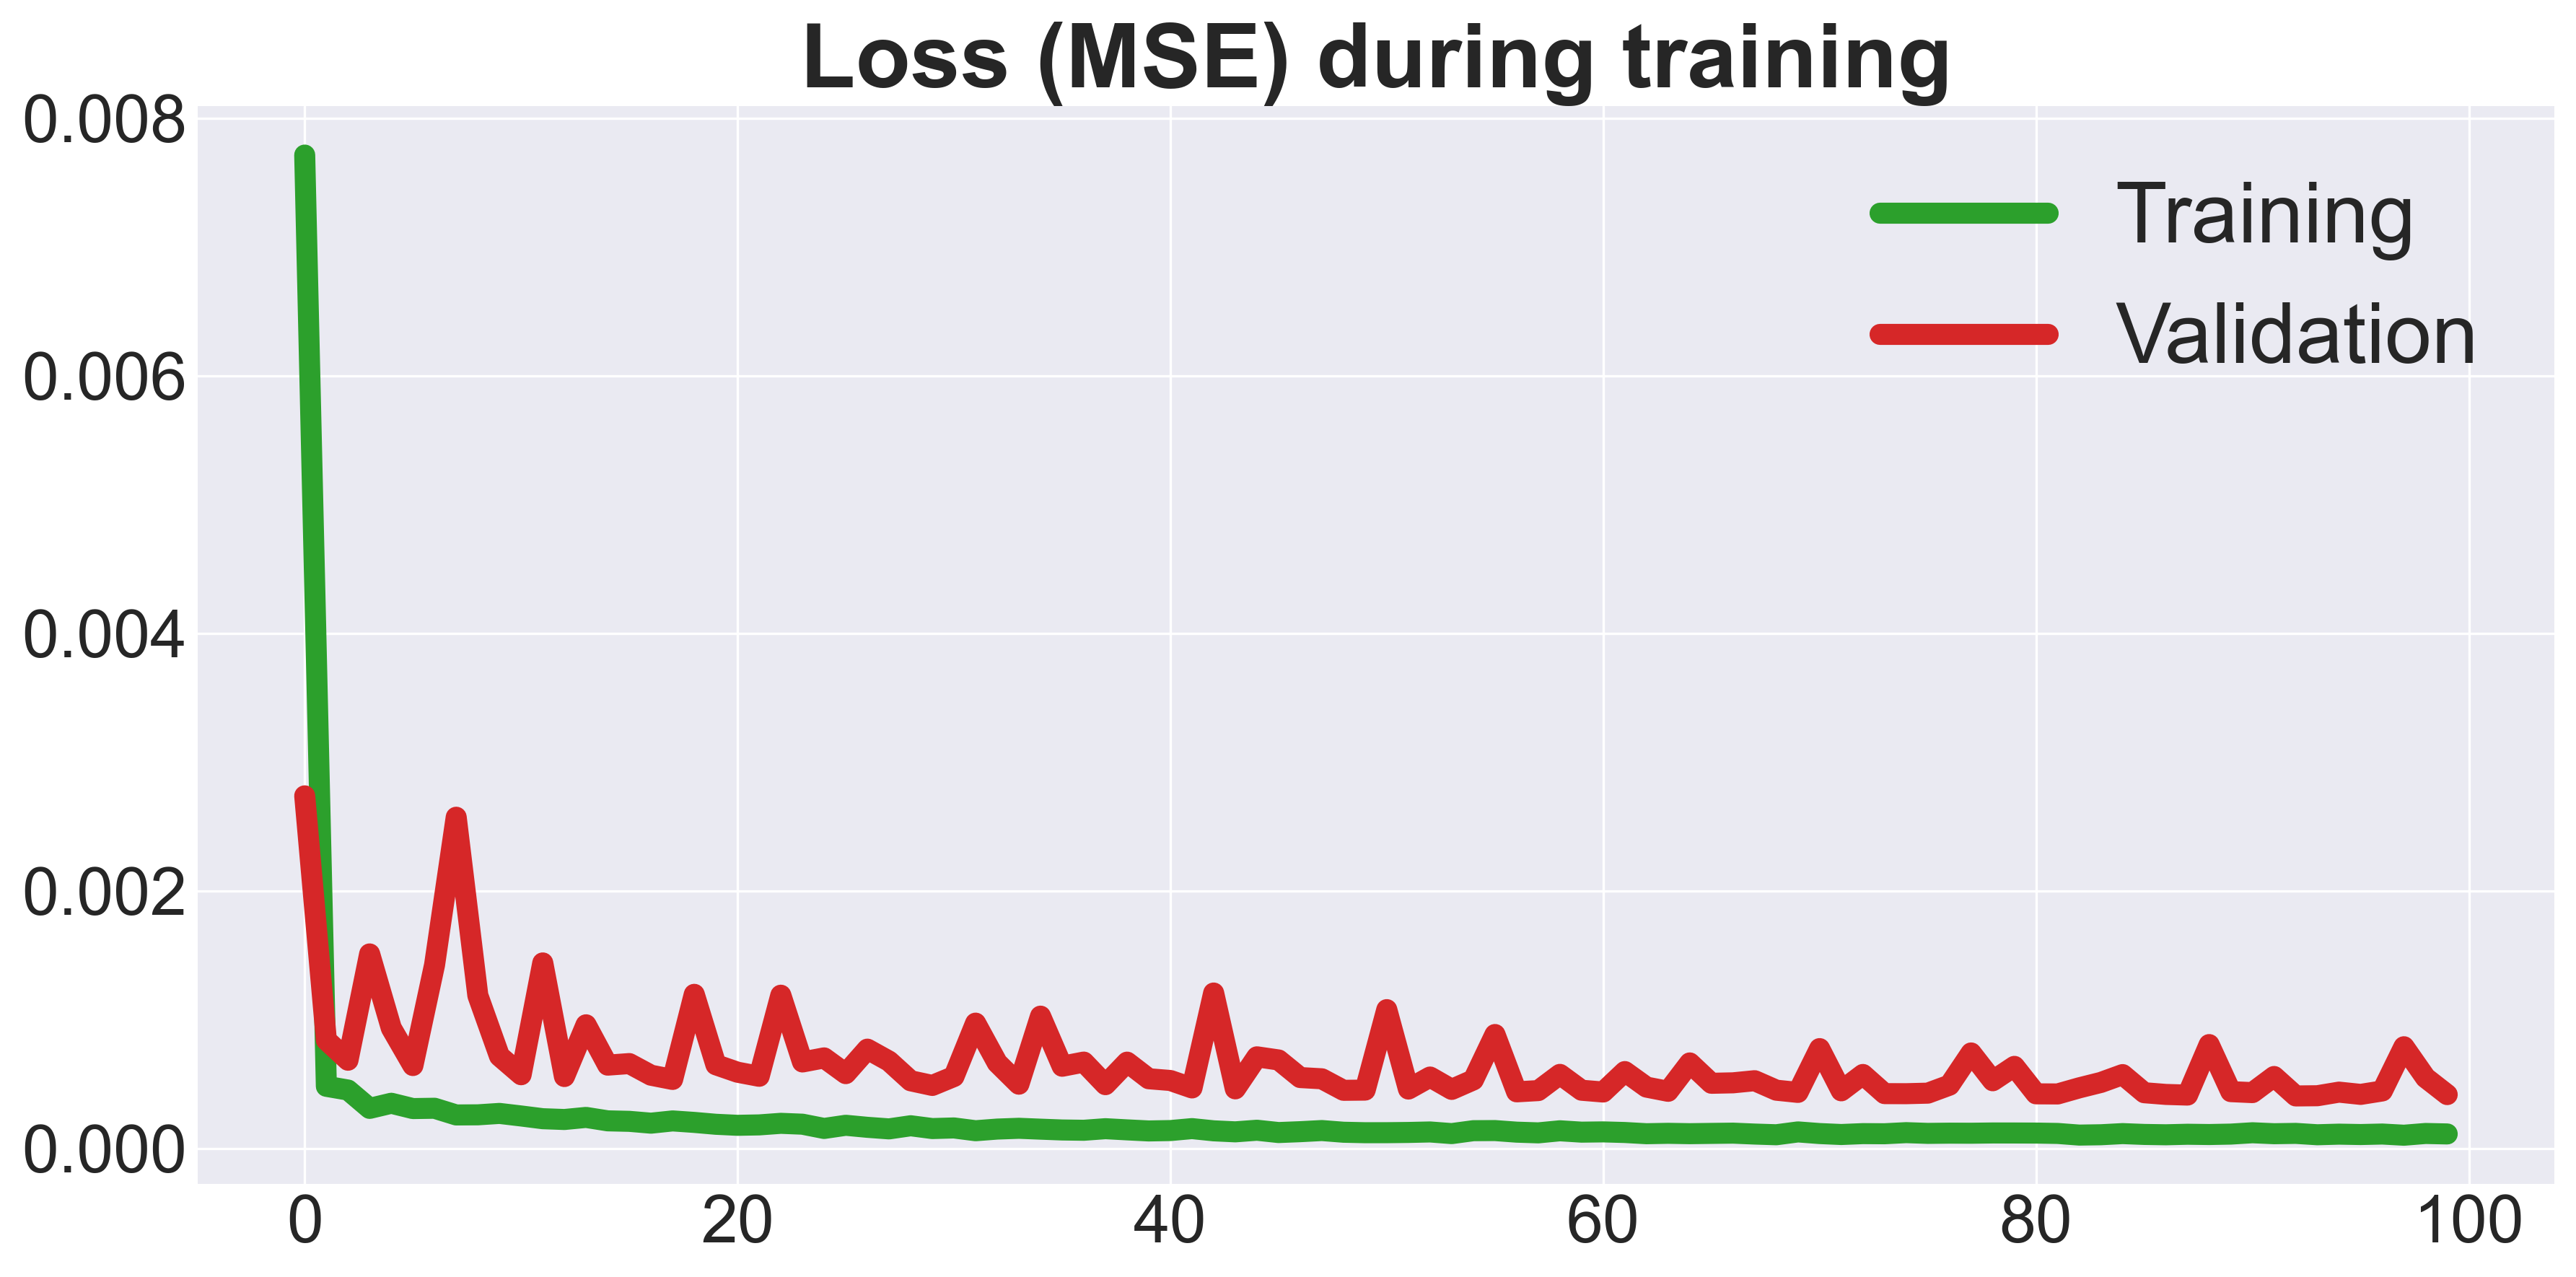

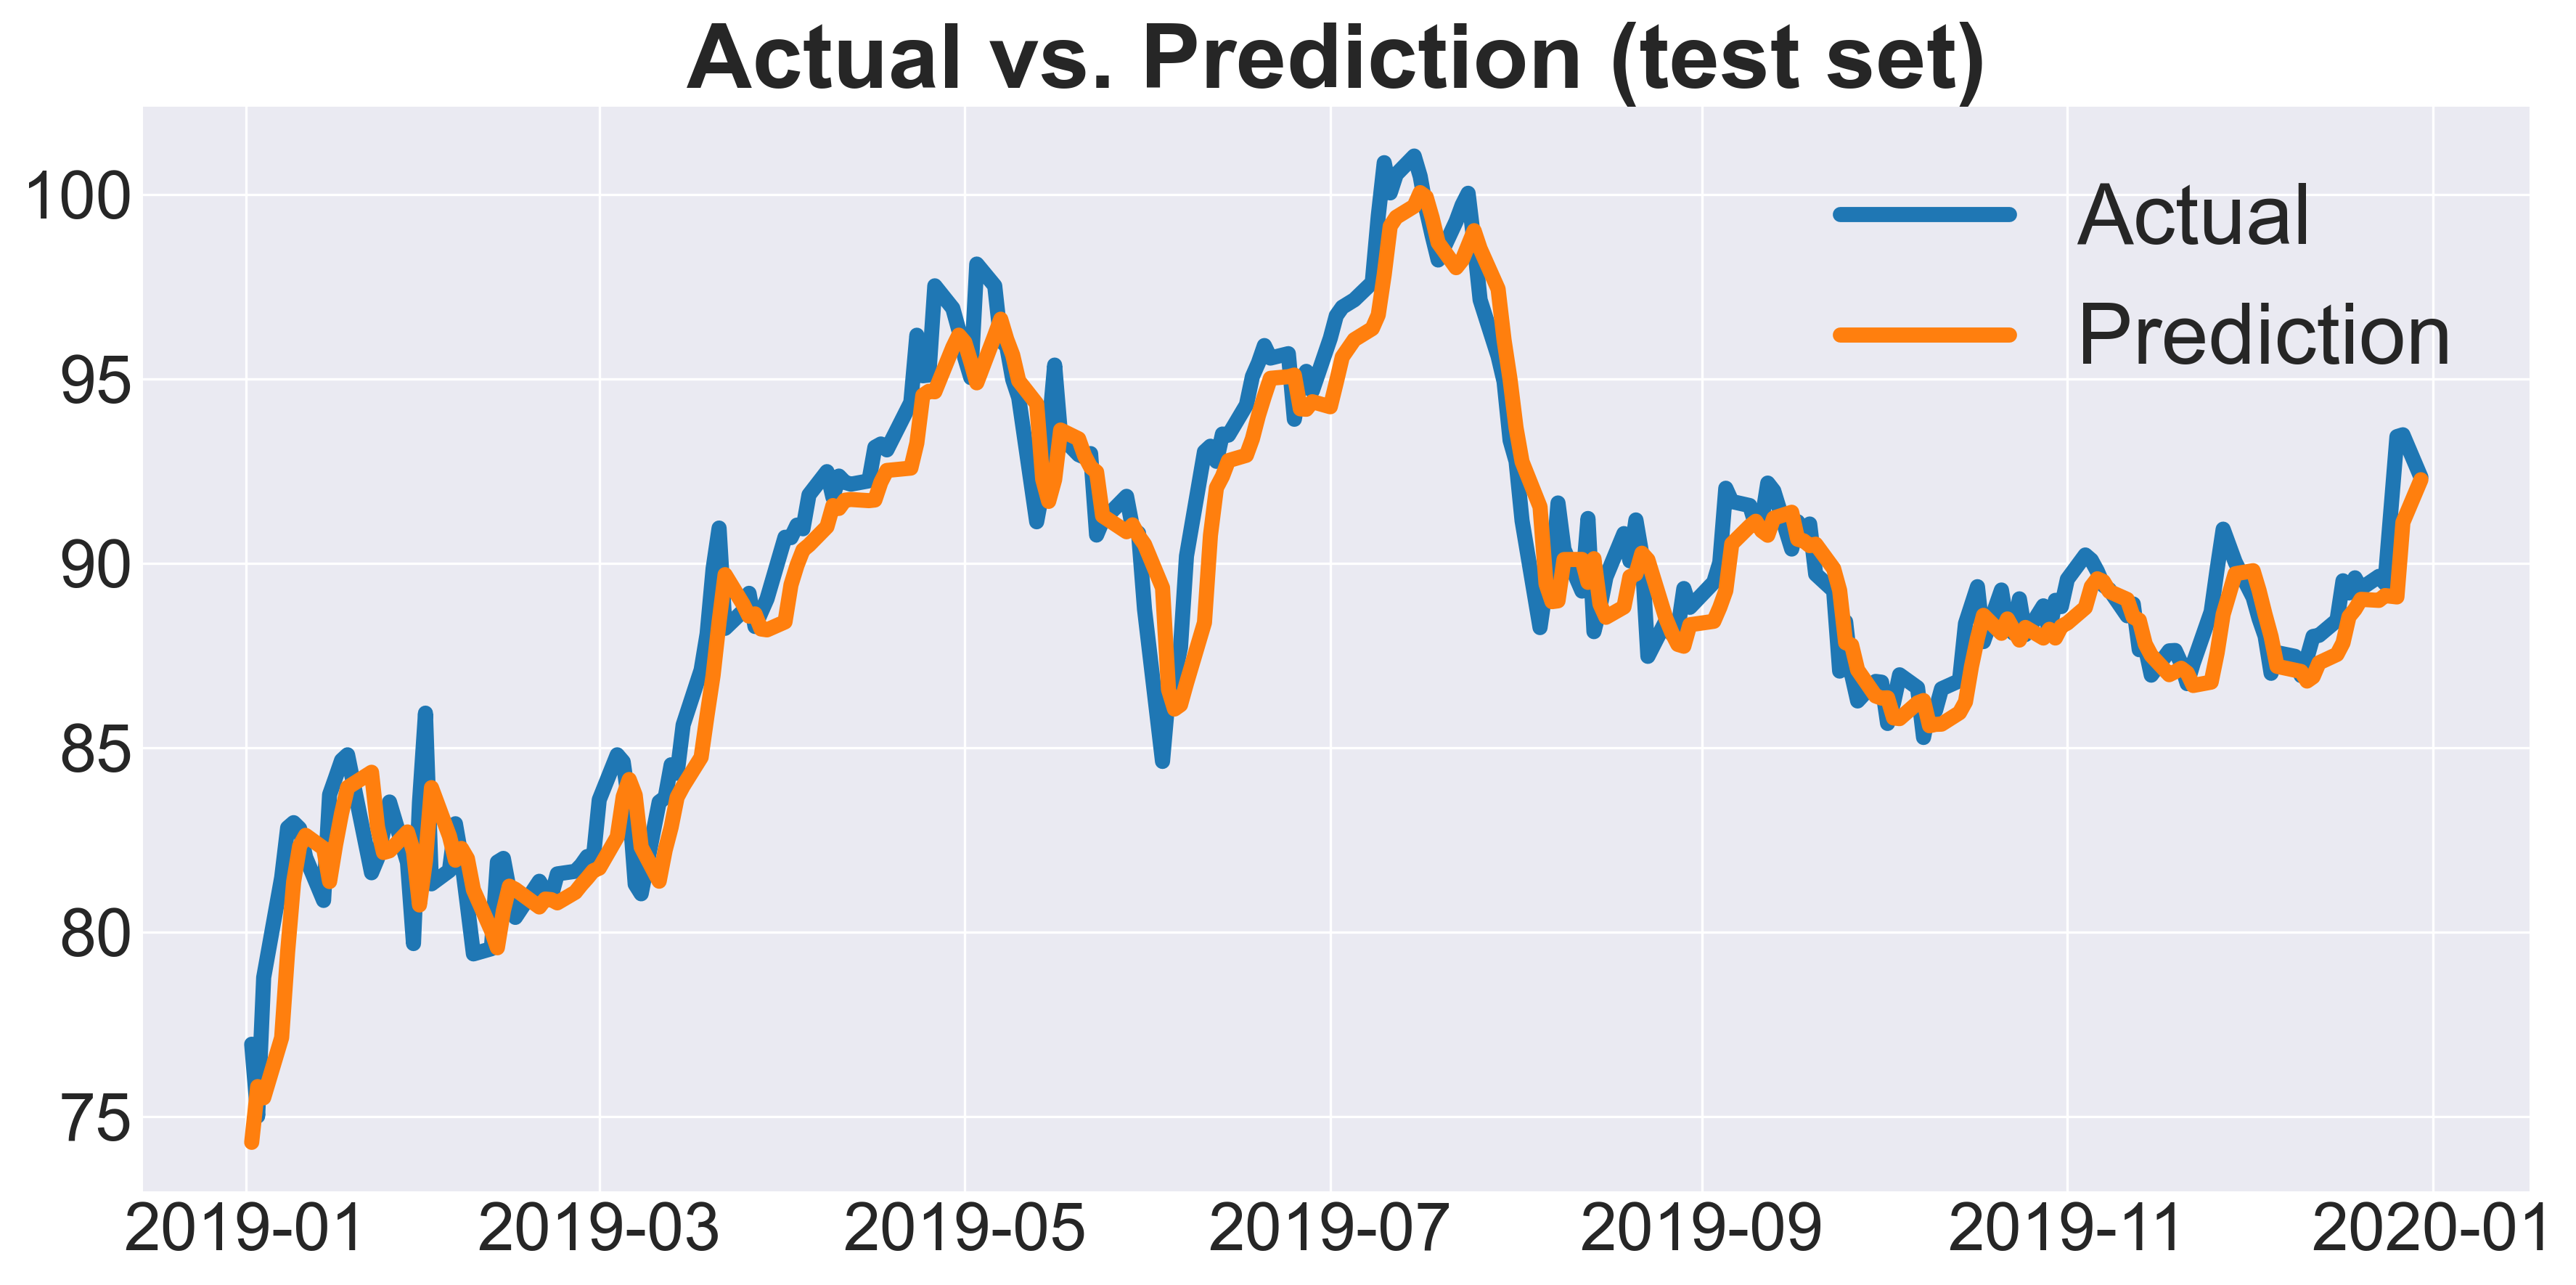

In [33]:
gru_history = gru_model.fit(X_train_norm, Y_train_norm, 
                            validation_split=0.2, 
                            epochs=100, 
                            batch_size=16, 
                            verbose=False)

# Predict
gru_preds_test = predict_print_MSE(gru_history, scaler)

# Plot loss and prediction
_ = plot_loss_preds(gru_history, gru_preds_test)

# Comparison of RNN, LSTM and GRU

RNN, LSTM and GRU performed similarly on our data set when regularization is added and when they are trained on the normalized data. The difference in their performance is well within the fluctuations due to the randomoness in the nature of model training, splitting validation/training sets, optimization etc. This is a toy data set with only one feature (Adj Close stock price) and very limited number of data points to see any difference between RNN, LSTM and GRU units. These models are capable of handling much more complex problems and larger data sets where their strengths/weaknesses become a factor.     

## Why Not Predict The Entire Next Year?

Can we iteratively predict the next day stock price so that we predict the entire the next year for example? Well, we can do that in theory but probably we should not. Because our model is trained to predict only the next day based on the previous days' data. Anyways, let's give it a try and predict the next 100-300 days beyond our actual data.

Iteratively predict the next day's stock price from previous n_days' data using the GRU model:

In [34]:
# Days to predict beyond test set
N_future_days = 100

future_preds = []

# Select last n_days of actual data to start with
moving_window = X_test_norm[-1::,:,:].copy()  

for _ in range(N_future_days):
    next_pred_norm = gru_model.predict(moving_window, verbose=0)
    next_pred = scaler.inverse_transform(next_pred_norm)
    future_preds.append(next_pred[0,0])
    # Now delete the first element of moving days 
    # and append the last pred to the end
    moving_window[0,:,0] = np.append(moving_window[0,1::,0], 
                                     next_pred_norm)

#future_preds

In [35]:
# Create a seperate df for the future preds 
# by creating future date starting 2020 
future_start = all_data.index[-1].strftime('%Y-%m-%d') # last day of data

new_index = pd.date_range(start=future_start, 
                          periods=N_future_days, 
                          freq='D', name='Date')

df_future = pd.DataFrame(index= new_index,
                         data= {'Adj Close':future_preds})

#df_future

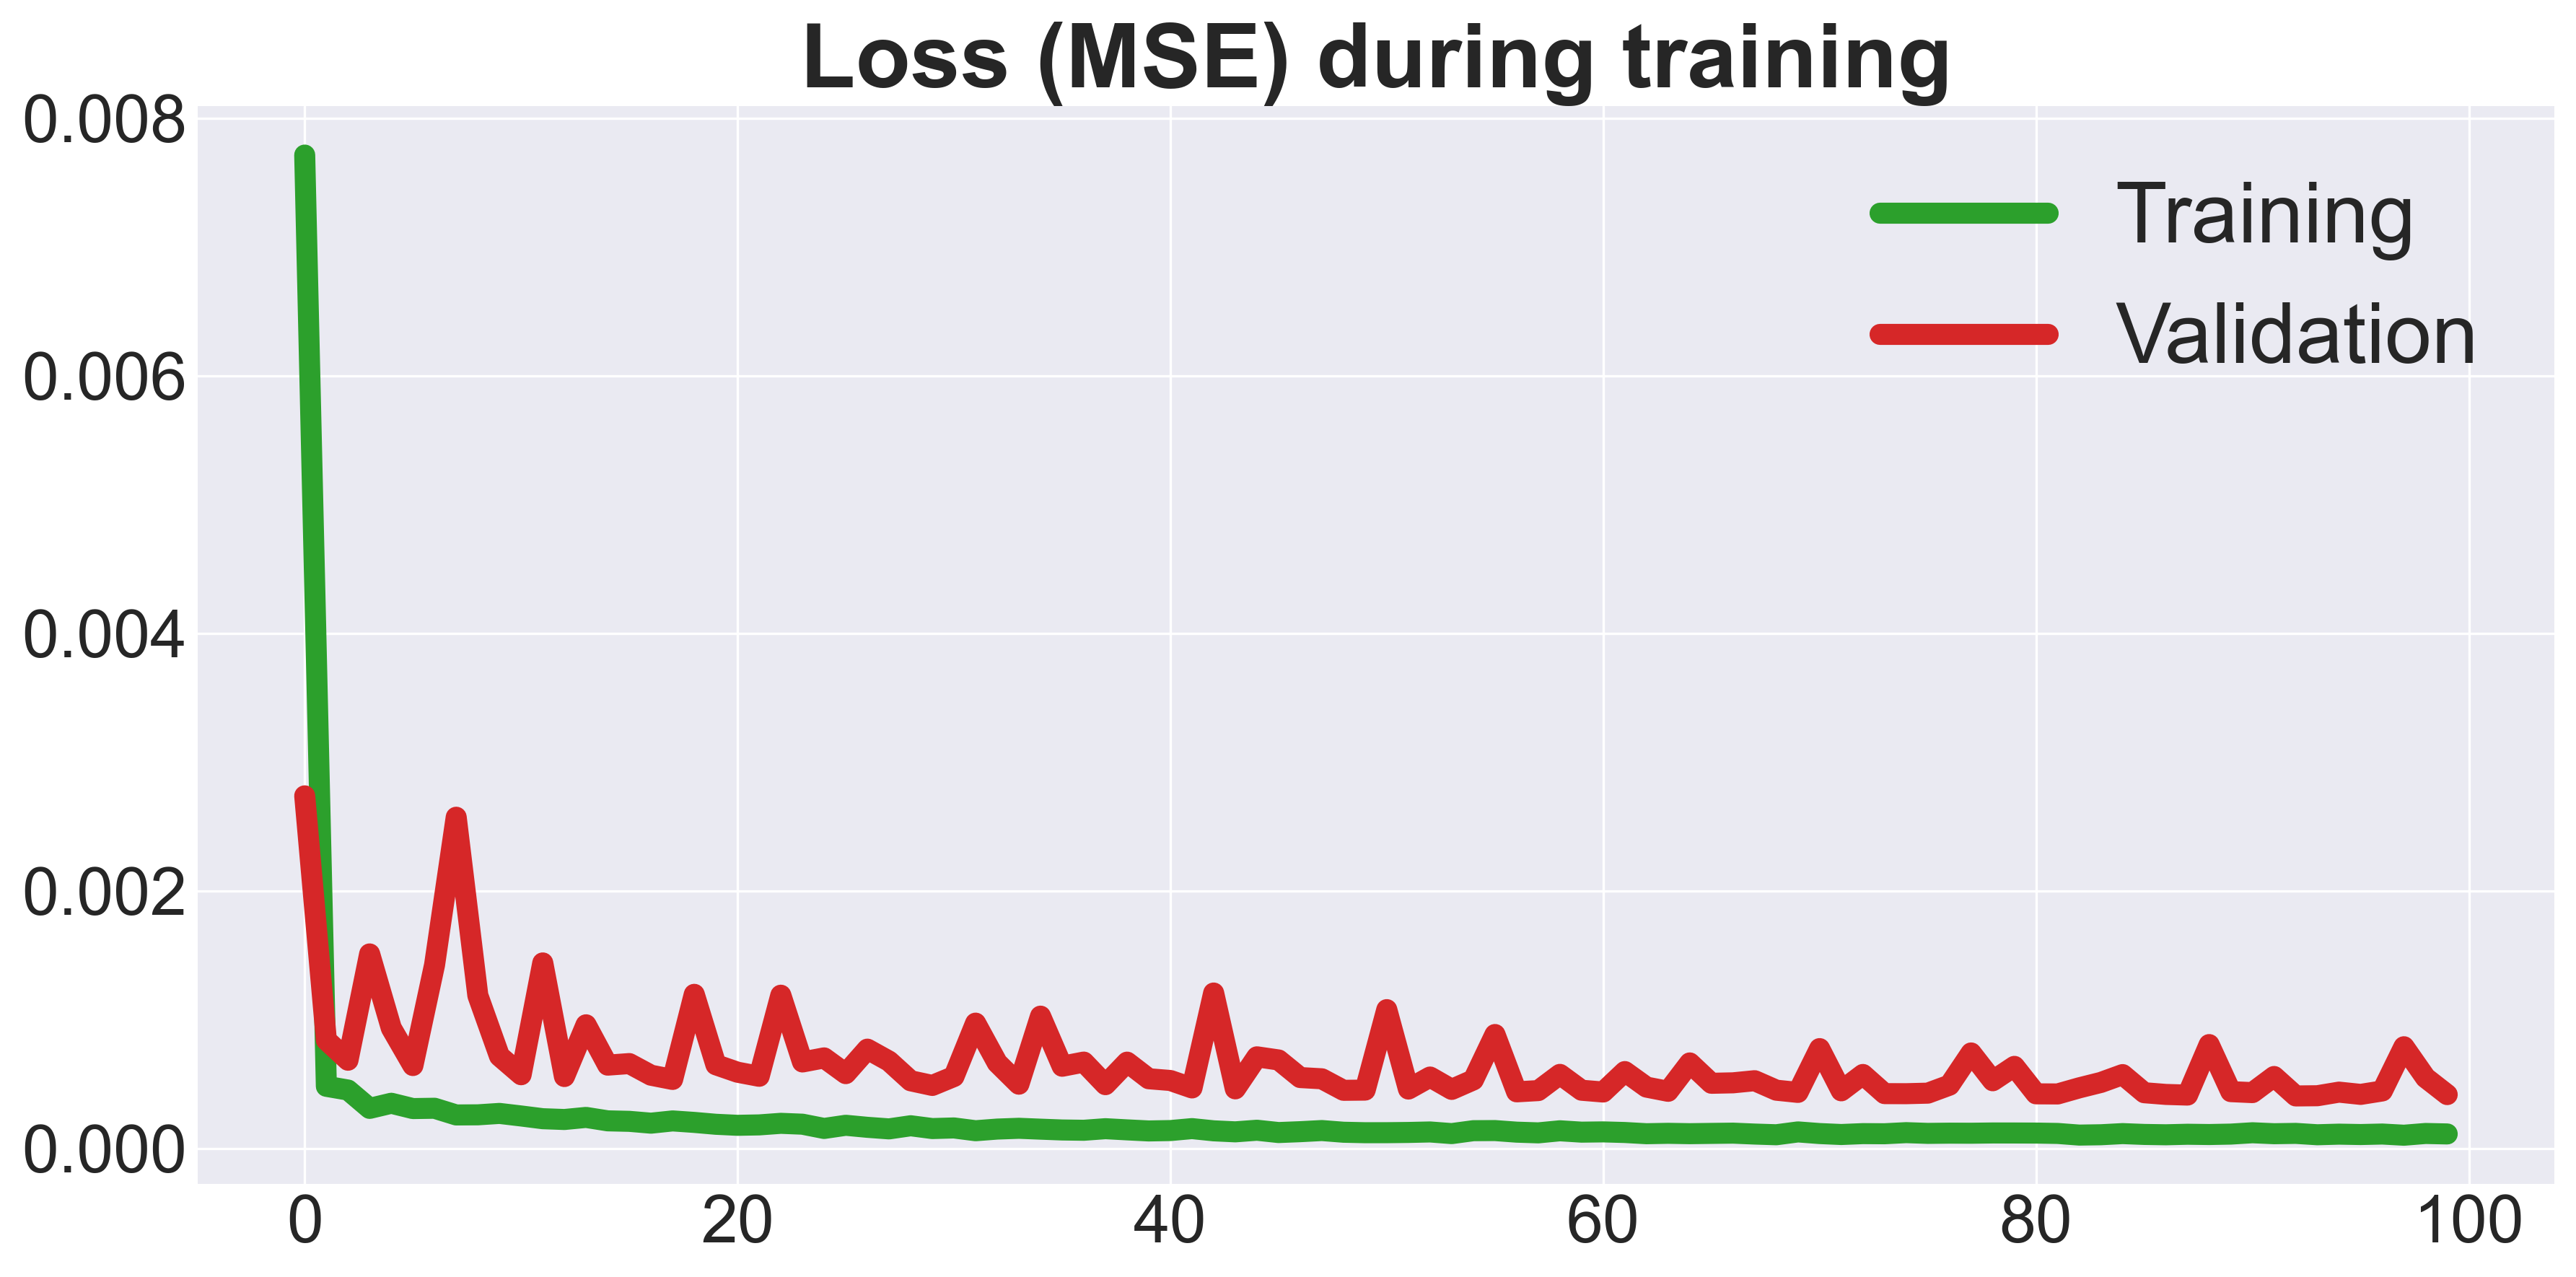

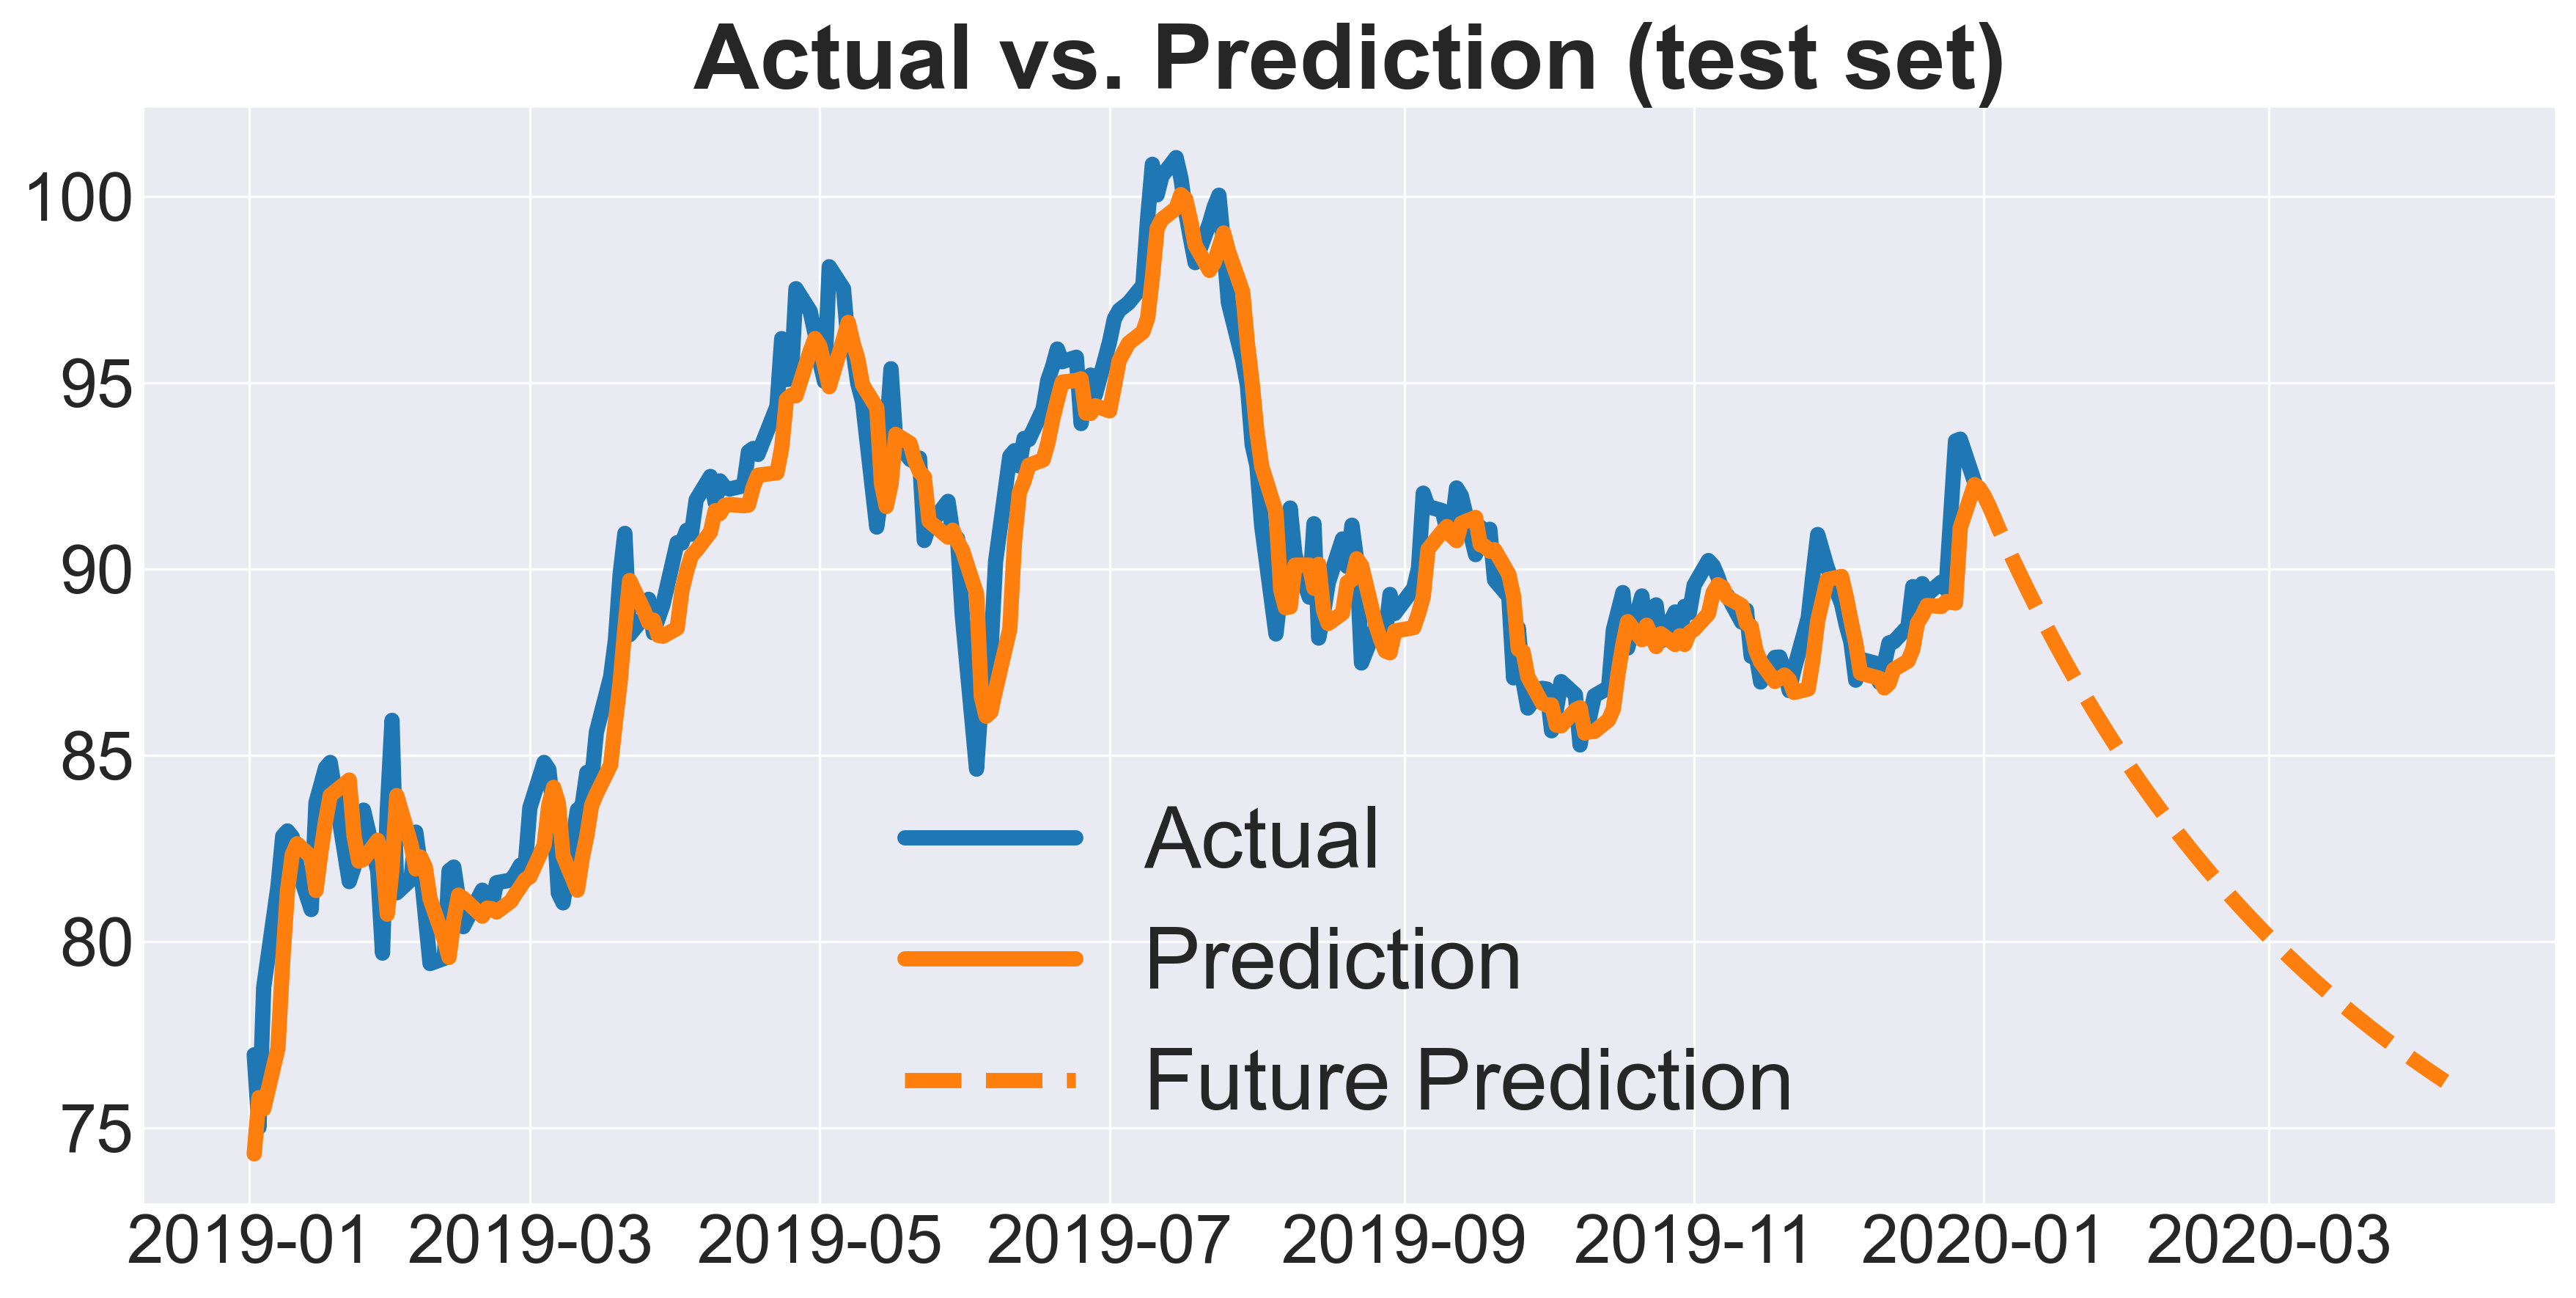

In [36]:
ax1, ax2 = plot_loss_preds(gru_history, gru_preds_test)

ax2.plot(df_future['Adj Close'], 
         color='tab:orange', 
         label='Future Prediction', 
         lw=5, linestyle='--')

_ = ax2.legend(fontsize=28)

# Save future prediction
fig2 = ax2.get_figure()
fig2.savefig('Figures/predict_future.jpg', dpi=500)

As we anticipated, any prediction beyond the next day does not make any sense! The trend learnt by the algorithm from the last day(s) of the test set is extrapolated to the future. Obviously this has no value.   